# Imports + Basic Setup

In [1]:
# Imports & basic setup
import joblib
import os
import tempfile
import time
import warnings
import pickle
import seaborn as sns

import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import LinearSVR
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Flatten

In [2]:
# Set random seeds for reproducibility
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

In [3]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU detected for TensorFlow.")

        # Test if XGBoost supports GPU
        try:
            _ = XGBRegressor(tree_method='gpu_hist')
            XGBOOST_TREE_METHOD = 'gpu_hist'
            print("XGBoost GPU mode enabled.")
        except:
            XGBOOST_TREE_METHOD = 'auto'
            print("XGBoost GPU not supported → using CPU mode.")

    except Exception as e:
        print("TensorFlow GPU init failed:", e)
        XGBOOST_TREE_METHOD = 'auto'
else:
    print("No GPU detected → CPU only.")
    XGBOOST_TREE_METHOD = 'auto'


No GPU detected → CPU only.


In [4]:
df=pd.read_csv("merged_energy_weather_data.csv")

In [5]:
df['datetime'] = pd.to_datetime(df['datetime'], utc=True).dt.tz_convert("Europe/London")
df = df.sort_values('datetime').reset_index(drop=True)

df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour
df['minute'] = df['datetime'].dt.minute
df['year'] = df['datetime'].dt.year
#weekday 0=mon 6=sun
df['weekday'] = df['datetime'].dt.weekday
#weekend flag ie 1=sat/sun 0=mon-fri
df['is_weekend']=df['weekday'].apply(lambda x: 1 if x>=5 else 0)


# EDA

In [ ]:
# 1. check missing values

In [ ]:
df.isnull().sum()

In [ ]:
# 2. check duplicates

In [ ]:
df.duplicated().sum()

In [ ]:
# Select only rows with duplicated datetime
duplicate_rows = df[df['datetime'].duplicated(keep=False)]

#Duplicate SETTLEMENT_DATE and datetime
duplicate_rows[['SETTLEMENT_DATE', 'datetime']]

In [ ]:
# 3. check for impossible values eg negative energy demand or solar/wind generation
#negative value for demand
demand_cols=["ND","TSD","ENGLAND_WALES_DEMAND","EMBEDDED_WIND_GENERATION","EMBEDDED_WIND_CAPACITY","EMBEDDED_SOLAR_GENERATION","EMBEDDED_SOLAR_CAPACITY"]

neg_demand=df[(df[demand_cols]<0).any(axis=1)]
print(f"Negative:          {len(neg_demand)} rows")

In [ ]:
#wind generation > capacity
exceed_wind=df[df["EMBEDDED_WIND_GENERATION"] > df["EMBEDDED_WIND_CAPACITY"]]

#solar generation> capacity
exceed_solar = df[df["EMBEDDED_SOLAR_GENERATION"] > df["EMBEDDED_SOLAR_CAPACITY"]]

print(f"Exceed Wind:          {len(exceed_wind)} rows")

print(f"Exceed Solar:          {len(exceed_solar)} rows")

In [ ]:
# Temperature spikes
temp_spikes = df[(df['temperature_2m'] < -30) | (df['temperature_2m'] > 50)]

# Wind spikes
wind_speed_spikes = df[(df['wind_speed_10m'] < 0) | (df['wind_speed_10m'] > 60)]

#Huminity
humidity_invalid = df[(df['relativehumidity_2m'] < 0) | (df['relativehumidity_2m'] > 100)]

# pressure
pressure_invalid = df[(df['pressure_msl'] < 800) | (df['pressure_msl'] > 1100)]

# wind direction
wind_direction_invalid = df[(df['wind_direction_10m'] < 0) | (df['wind_direction_10m'] > 360)]

# precipitation
precipitation_negative = df[df['precipitation'] < 0]

print(f"Temperature unrealistic:          {len(temp_spikes)} rows")
print(f"Wind speed unrealistic:           {len(wind_speed_spikes)} rows")
print(f"Humidity invalid:                 {len(humidity_invalid)} rows")
print(f"Pressure invalid:                 {len(pressure_invalid)} rows")
print(f"Wind direction invalid:           {len(wind_direction_invalid)} rows")
print(f"Negative precipitation:           {len(precipitation_negative)} rows")

In [ ]:
#mismatch date and time
df['SETTLEMENT_DATE'] = (
    pd.to_datetime(df['SETTLEMENT_DATE'], utc=True)
      .dt.tz_convert("Europe/London")
)

settlement_dates = df['SETTLEMENT_DATE'].dt.date
datetime_dates   = df['datetime'].dt.date

mismatch = df[settlement_dates != datetime_dates]

print(mismatch[['SETTLEMENT_DATE', 'datetime']])

In [ ]:
# 4. plot full time series
# line chart of demand over full time period
# ENGLAND_WALES_DEMAND vs datetime
# to identify overall trends(is demand rising/falling), seasonal patterns(daily/weekly/annual cycles), anomalies(spikes/drops)

In [ ]:
import matplotlib.pyplot as plt

df_2023=df[df['datetime'].dt.year==2023]
df_2024=df[df['datetime'].dt.year==2024]
df_2025=df[df['datetime'].dt.year==2025]

fig,axes=plt.subplots(3,1,figsize=(16,12))

#2023
axes[0].plot(df_2023['datetime'],df_2023['ENGLAND_WALES_DEMAND'],color='lightblue', linewidth=0.8)
axes[0].set_title('England & Wales Demand 2023')
axes[0].set_xlabel('')
axes[0].set_ylabel('MW')
axes[0].grid(True)

#2024
axes[1].plot(df_2024['datetime'],df_2024['ENGLAND_WALES_DEMAND'],color='purple', linewidth=0.8)
axes[1].set_title('England & Wales Demand 2024')
axes[1].set_xlabel('')
axes[1].set_ylabel('MW')
axes[1].grid(True)

#2025
axes[2].plot(df_2025['datetime'],df_2025['ENGLAND_WALES_DEMAND'],color='pink', linewidth=0.8)
axes[2].set_title('England & Wales Demand 2025')
axes[2].set_xlabel('')
axes[2].set_ylabel('MW')
axes[2].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import MSTL


df['datetime'] = pd.to_datetime(df['datetime'], utc=True, errors='coerce')
df['datetime'] = df['datetime'].dt.tz_localize(None)
df = df.set_index('datetime')



ts = df['ENGLAND_WALES_DEMAND']

mstl = MSTL(
    ts,
    periods=[48, 336],
    stl_kwargs={
        "seasonal_deg": 1,
        "trend_deg": 1,
        "trend_jump": 5
    }
)

res = mstl.fit()


trend = res.trend
seasonal_daily = res.seasonal['seasonal_48']
seasonal_weekly = res.seasonal['seasonal_336']
residual = res.resid


fig, axes = plt.subplots(4, 1, figsize=(15, 14), sharex=True)

axes[0].plot(trend, linewidth=0.9)
axes[0].set_title('Trend')

axes[1].plot(seasonal_daily, linewidth=0.9)
axes[1].set_title('Daily Seasonality (48)')

axes[2].plot(seasonal_weekly, linewidth=0.9)
axes[2].set_title('Weekly Seasonality (336)')

axes[3].plot(residual, linewidth=0.7)
axes[3].set_title('Residual')

plt.tight_layout()
plt.show()

In [ ]:
# 5. plot seasonal patterns
# demand by time of day
# demand by day of week
# demand by month of year
# to identify regular fluctuations in demand associated with daily routines, weekly work patterns, seasonal changes

In [ ]:
fig,axes=plt.subplots(1,3,figsize=(18,5))
sns.lineplot(data=df,x='hour',y='ENGLAND_WALES_DEMAND',ax=axes[0])
axes[0].set_title('Demand by Hour of Day')
sns.lineplot(data=df,x='weekday',y='ENGLAND_WALES_DEMAND',ax=axes[1])
axes[1].set_title('Demand by Day of Week')
sns.lineplot(data=df,x='month',y='ENGLAND_WALES_DEMAND',ax=axes[2])
axes[2].set_title('Demand by Month of Year')
plt.tight_layout
plt.show()

In [ ]:
# 6. plot weather vs demand
# scatter plots of temperature, wind speed, solar radiation vs ENGLAND_WALES_DEMAND
# to identify relationships between weather conditions and energy demand patterns

In [ ]:
weather_vars= ['temperature_2m','relativehumidity_2m','wind_speed_10m', 'EMBEDDED_SOLAR_GENERATION']
fig,axes=plt.subplots(2,2,figsize=(15,10))
axes=axes.flatten()
for i,col in enumerate(weather_vars):
    sns.scatterplot(data=df.iloc[::10],x=col,y='ENGLAND_WALES_DEMAND',alpha=0.1,ax=axes[i])
    axes[i].set_title(f'{col} vs ENGLAND_WALES_DEMAND')
plt.tight_layout()
plt.show()


In [ ]:
# 7. summary statistics
# mean, median, stddev, min, max of key variables
# to understand central tendencies and variability in energy demand and weather conditions

In [ ]:
# Select key variables
key_vars = [
    "ENGLAND_WALES_DEMAND",
    "EMBEDDED_WIND_GENERATION",
    "EMBEDDED_SOLAR_GENERATION",
    "NON_BM_STOR",
    "temperature_2m",
    "relativehumidity_2m",
    "pressure_msl",
    "wind_speed_10m",
    "wind_direction_10m",
    "precipitation"
]

# Filter only variables that actually exist in the dataframe
key_vars = [v for v in key_vars if v in df.columns]

# Compute summary statistics
summary = df[key_vars].agg(["mean", "median", "std", "min", "max"]).T   # .T --> transpose

# Print Summary
print("\nSummary Statistics (Mean, Median, Standard Deviation, Min, Max):\n")
print(summary.round(2))

In [ ]:
# 8.distribution plots
# histograms/kde plots of ENGLAND_WALES_DEMAND, temperature, wind speed, solar radiation
# to visualize data distributions and identify skewness, kurtosis, outliers

In [ ]:
# Select variables for distribution plots
dist_vars = [
    "ENGLAND_WALES_DEMAND",
    "temperature_2m",
    "wind_speed_10m",
    "EMBEDDED_SOLAR_GENERATION"   # using solar generation as solar radiation proxy
]

# Plot settings
plt.style.use("seaborn-v0_8")
plt.figure(figsize=(14, 10))

for i, var in enumerate(dist_vars, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[var].dropna(), kde=True, bins=40)
    var_name = var.replace("_", " ").lower()
    plt.title(f"Distribution of {var_name}")
    plt.xlabel(var)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


In [ ]:
# 9. box plots
# box plots of ENGLAND_WALES_DEMAND by month
# to identify monthly variations and outliers in demand patterns

# wq:nid 1 or 3 box plot? cuz around 3 years

In [ ]:
# Ensure your datetime column is in datetime format
# df['datetime'] = pd.to_datetime(df['datetime'])

# Extract month from datetime
# df['month'] = df.index.month


# Set plot style
# plt.style.use("seaborn-v0_8")
plt.figure(figsize=(12, 6))

# Create box plot
sns.boxplot(x='month', y='ENGLAND_WALES_DEMAND', data=df)
plt.title('ENGLAND WALES DEMAND by Month')
plt.xlabel('Month')
plt.ylabel('Electricity Demand (MW)')
plt.xticks(ticks=range(12), labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
])
plt.show()

In [ ]:
# 10. correlation
# check pearson correlation between Demand and weather variables

In [ ]:
corr_cols=['ENGLAND_WALES_DEMAND','temperature_2m','relativehumidity_2m','wind_speed_10m','precipitation','pressure_msl','EMBEDDED_WIND_GENERATION','EMBEDDED_SOLAR_GENERATION']
plt.figure(figsize=(10,8))
sns.heatmap(df[corr_cols].corr(),annot=True,cmap='coolwarm',fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [ ]:
# 11. stationarity check
# to determine if the time series data (e.g., ENGLAND_WALES_DEMAND) is stationary, which is important for time series modeling
# using ADF test or KPSS test
# rolling mean and stddev plots

In [ ]:
from statsmodels.tsa.stattools import adfuller
series=df['ENGLAND_WALES_DEMAND'].dropna()
result=adfuller(series.iloc[:10000],autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
if result[1] <= 0.05:
    print("The time series is stationary.")
else:
    print("The time series is non-stationary.")

In [ ]:
target_col='ENGLAND_WALES_DEMAND'
window_size=48*7  # one week of half-hourly data

if 'datetime' not in df.columns:
    df = df.reset_index()

rolling_mean=df[target_col].rolling(window=window_size).mean()
rolling_std=df[target_col].rolling(window=window_size).std()


plt.figure(figsize=(15,8))
plt.plot(df['datetime'],df[target_col], label='Original Demand', alpha=0.3,color='gray')
plt.plot(df['datetime'],rolling_mean, label=f'Rolling Mean ({window_size} periods)', color='blue',linewidth=2)
plt.plot(df['datetime'],rolling_std, label=f'Rolling Std Dev ({window_size} periods)', color='red',linewidth=2)
plt.title(f'Stationarity check: rolling mean and stddev of {target_col} (window=7 days)',fontsize=14)
plt.xlabel('Date')
plt.ylabel('Demand(MW)')
plt.legend(loc='best')
plt.grid(True,which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()
print("#remark")
print("1.trend:if the blue line(rolling mean) shows a consistent upward or downward slope over time, it indicates a trend in the data.")
print("2.variance:if red line(rolling std) increases or decreases over time, series has changing variance(heteroscedasticity/non stationary)")
print("3.seasonality:repeating waves in rolling mean indicate seasonality")

# Part A

## Train Test Split

In [6]:

target = 'ENGLAND_WALES_DEMAND'

# Features
time_features = ['hour', 'day', 'month','year','is_weekend','weekday']
weather_features = ['temperature_2m', 'relativehumidity_2m', 'pressure_msl',
                    'wind_speed_10m', 'wind_direction_10m', 'precipitation']
grid_features = [
    'EMBEDDED_WIND_GENERATION', 'EMBEDDED_WIND_CAPACITY',
    'EMBEDDED_SOLAR_GENERATION', 'EMBEDDED_SOLAR_CAPACITY',
    'NON_BM_STOR', 'PUMP_STORAGE_PUMPING', 'SCOTTISH_TRANSFER',
    'IFA_FLOW', 'IFA2_FLOW', 'BRITNED_FLOW', 'MOYLE_FLOW',
    'EAST_WEST_FLOW', 'NEMO_FLOW', 'NSL_FLOW', 'ELECLINK_FLOW',
    'VIKING_FLOW', 'GREENLINK_FLOW'
]

feature_cols = weather_features + time_features + grid_features

model_df = df.dropna(subset=feature_cols + [target]).copy()

# split based on the date time
# 2023, 2024 -> train
train_df = model_df[model_df.year.isin([2023, 2024])].sort_values("datetime")
print(train_df.head())

# 2025 -> test
test_df = model_df[model_df.year == 2025].sort_values("datetime")
print(test_df.head())

# train set
X_train = train_df[feature_cols]
y_train = train_df[target]

# test set
X_test = test_df[feature_cols]
y_test = test_df[target]

print(f"Train Set: {X_train.shape}")
print(f"Test Set: {X_test.shape}")


             SETTLEMENT_DATE  SETTLEMENT_PERIOD     ND    TSD  \
0  2023-01-01 00:00:00+00:00                  1  21043  24680   
1  2023-01-01 00:00:00+00:00                  2  21756  25289   
2  2023-01-01 00:00:00+00:00                  3  21348  25269   
3  2023-01-01 00:00:00+00:00                  4  20586  24574   
4  2023-01-01 00:00:00+00:00                  5  19781  24135   

   ENGLAND_WALES_DEMAND  EMBEDDED_WIND_GENERATION  EMBEDDED_WIND_CAPACITY  \
0                 18995                      2815                    6545   
1                 19730                      2793                    6545   
2                 19327                      2773                    6545   
3                 18589                      2753                    6545   
4                 17806                      2712                    6545   

   EMBEDDED_SOLAR_GENERATION  EMBEDDED_SOLAR_CAPACITY  NON_BM_STOR  ...  \
0                          0                    15037            0  ...

## Scaling

In [7]:
#Scaling
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled  = scaler_X.transform(X_test)

scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1,1))
y_test_scaled  = scaler_y.transform(y_test.values.reshape(-1,1))


## Create Sequences for LSTM

In [8]:
def create_sequences(X, y, timesteps):
    X_seq, y_seq = [], []
    for i in range(len(X) - timesteps):
        X_seq.append(X[i:i+timesteps])
        y_seq.append(y[i+timesteps])
    return np.array(X_seq), np.array(y_seq)


## Helper function for evaluation

In [9]:
def timed_fit(model, X, y):
    start = time.time()
    model.fit(X, y)
    end = time.time()
    return end - start


def timed_predict(model, X):
    start = time.time()
    pred = model.predict(X)
    end = time.time()
    return pred, (end - start) / len(X)


def compute_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "MSE": mse,
        "RMSE": np.sqrt(mse),
        "R2": r2_score(y_true, y_pred),
        "MAPE": mean_absolute_percentage_error(y_true, y_pred),
    }


def pack_result_row(model_name, metrics, train_time, inference_time, model_size):
    row = {"Model": model_name}
    row.update(metrics)
    row.update({
        "Training Time (s)": train_time,
        "Inference Time per Sample (s)": inference_time,
        "Model Size (MB)": model_size,
    })
    return row


def get_model_size_mb(model):
    """Generalized model size checker for sklearn, xgboost, keras."""
    try:
        with tempfile.NamedTemporaryFile(delete=False) as tmp:
            tmp.close()

            if isinstance(model, tf.keras.Model):
                filepath = tmp.name + ".h5"
                model.save(filepath)
                size = os.path.getsize(filepath)
                os.remove(filepath)
            else:
                joblib.dump(model, tmp.name)
                size = os.path.getsize(tmp.name)

            if os.path.exists(tmp.name):
                os.remove(tmp.name)

        return size / (1024 * 1024)

    except Exception as e:
        print(f"[Size Error] {e}")
        return np.nan

## Neural classes (changed)

In [10]:
# Neural classes (MLP, LSTM_Model, TemporalCNN)
class MLP:
    def __init__(self, input_shape,hidden_units=32, epochs=50, batch_size=32):
        self.input_shape = input_shape
        self.hidden_units=hidden_units
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = self.build_model()

    def build_model(self):
        model = Sequential([
            Dense(self.hidden_units, activation='relu', input_shape=self.input_shape),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse')
        return model

    def fit_predict(self, X_train, y_train, X_test):
        start_train = time.time()
        self.model.fit(X_train, y_train, epochs=self.epochs, batch_size=self.batch_size, verbose=0)
        training_time = time.time() - start_train

        start_pred = time.time()
        y_pred = self.model.predict(X_test).flatten()
        inference_time = (time.time() - start_pred) / X_test.shape[0]
        return y_pred, training_time, inference_time

    def get_model_size(self):
        tmp_path = "temp_mlp_model.keras"
        self.model.save(tmp_path)
        size = os.path.getsize(tmp_path) / 1e6
        os.remove(tmp_path)
        return size

class LSTM_Model:
    def __init__(self, input_shape,units=50, epochs=50, batch_size=32):
        self.input_shape = input_shape
        self.epochs = epochs
        self.units=units
        self.batch_size = batch_size
        self.model = self.build_model()

    def build_model(self):
        model = Sequential([
            LSTM(self.units, activation='tanh', input_shape=self.input_shape),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse')
        return model

    def fit_predict(self, X_train, y_train, X_test):
        start_train = time.time()
        self.model.fit(X_train, y_train, epochs=self.epochs, batch_size=self.batch_size, verbose=0)
        training_time = time.time() - start_train

        start_pred = time.time()
        y_pred = self.model.predict(X_test)
        inference_time = (time.time() - start_pred) / X_test.shape[0]
        return y_pred, training_time, inference_time

    def get_model_size(self):
        tmp_path = "temp_lstm_model.keras"
        self.model.save(tmp_path)
        size = os.path.getsize(tmp_path) / 1e6
        os.remove(tmp_path)
        return size


class TemporalCNN:
    def __init__(self, input_shape,filters=32,epochs=50, batch_size=32):
        self.input_shape = input_shape
        self.filters=filters
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = self.build_model()

    def build_model(self):
        model = Sequential([
            Conv1D(self.filters, kernel_size=1, activation='relu', input_shape=self.input_shape),
            Conv1D(max(1, self.filters//2), kernel_size=1, activation='relu'),
            Flatten(),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse')
        return model

    def fit_predict(self, X_train, y_train, X_test):
        start_train = time.time()
        self.model.fit(X_train, y_train, epochs=self.epochs, batch_size=self.batch_size, verbose=0)
        training_time = time.time() - start_train

        start_pred = time.time()
        y_pred = self.model.predict(X_test).flatten()
        inference_time = (time.time() - start_pred) / X_test.shape[0]
        return y_pred, training_time, inference_time

    def get_model_size(self):
        tmp_path = "temp_temporal_cnn.keras"
        self.model.save(tmp_path)
        size = os.path.getsize(tmp_path) / 1e6
        os.remove(tmp_path)
        return size

## Train model function

In [11]:
def train_model(
    X_test, y_test,
    X_train, y_train,
    X_test_scaled, X_train_scaled,
    y_train_scaled, scaler_y,
    scale=True
):

    models = {
        "Linear Regression": LinearRegression(),
        "SVR": LinearSVR(max_iter=5000),
        "Ridge Regression": Ridge(alpha=1.0),
        "Decision Tree": DecisionTreeRegressor(random_state=42),
        "XGBoost": XGBRegressor(
            n_estimators=100,
            random_state=42,
            n_jobs=-1,
            tree_method=XGBOOST_TREE_METHOD
        ),
        "Random Forest": RandomForestRegressor(
            n_estimators=100,
            random_state=42,
            n_jobs=-1
        ),
        "MLP": "MLP",
        "Temporal CNN": "Temporal CNN"
    }

    results_list = []
    predictions = {}
    models_dict = {}

    for name, model in models.items():
        print(f"\n===== Training {name} =====")

        # Classical ML models
        if name not in ["MLP", "Temporal CNN"]:

            # Train
            train_time = time.time()
            model.fit(X_train, y_train)
            train_time = time.time() - train_time

            # Predict
            pred_start = time.time()
            y_pred = model.predict(X_test)
            inference_time = (time.time() - pred_start) / len(X_test)

            # Save
            predictions[name] = y_pred
            models_dict[name] = model

            # Metrics
            metrics = compute_metrics(y_test, y_pred)
            model_size = get_model_size_mb(model)
            results_list.append(
                pack_result_row(name, metrics, train_time, inference_time, model_size)
            )

        # MLP Neural Network
        elif name == "MLP":
            mlp = MLP(input_shape=(X_train_scaled.shape[1],))
            y_pred_scaled, train_time, inference_time = mlp.fit_predict(
                X_train_scaled, y_train_scaled, X_test_scaled
            )

            # Inverse scale
            y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

            predictions[name] = y_pred
            models_dict[name] = mlp

            metrics = compute_metrics(y_test, y_pred)
            model_size = mlp.get_model_size()
            results_list.append(
                pack_result_row(name, metrics, train_time, inference_time, model_size)
            )

        # Temporal CNN
        elif name == "Temporal CNN":
            X_train_seq = X_train_scaled.reshape(len(X_train_scaled), 1, -1)
            X_test_seq  = X_test_scaled.reshape(len(X_test_scaled), 1, -1)

            cnn = TemporalCNN(input_shape=(1, X_train_scaled.shape[1]))
            y_pred_scaled, train_time, inference_time = cnn.fit_predict(
                X_train_seq, y_train_scaled, X_test_seq
            )

            # Inverse scale
            y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

            predictions[name] = y_pred
            models_dict[name] = cnn

            metrics = compute_metrics(y_test, y_pred)
            model_size = cnn.get_model_size()
            results_list.append(
                pack_result_row(name, metrics, train_time, inference_time, model_size)
            )


    return predictions, results_list, models_dict

In [12]:
# LSTM training wrapper
def train_LSTM(
    predictions, results_list,
    X_train_raw, X_test_raw,
    y_train_raw, y_test_raw,
    scaler_y,
    timesteps=24, scale=True
):
    # Ensure inputs are numpy arrays for create_sequences
    X_train_np = X_train_raw if isinstance(X_train_raw, np.ndarray) else X_train_raw.to_numpy()
    X_test_np  = X_test_raw if isinstance(X_test_raw, np.ndarray) else X_test_raw.to_numpy()
    y_train_np = y_train_raw if isinstance(y_train_raw, np.ndarray) else y_train_raw.to_numpy()
    y_test_np  = y_test_raw if isinstance(y_test_raw, np.ndarray) else y_test_raw.to_numpy()

    # Create sequences
    X_train_seq, y_train_seq = create_sequences(X_train_np, y_train_np, timesteps)
    X_test_seq, y_test_seq   = create_sequences(X_test_np, y_test_np, timesteps)

    # Initialize LSTM model with correct input shape (timesteps, features)
    lstm = LSTM_Model(input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]))

    y_pred_scaled, train_time, inference_time = lstm.fit_predict(
        X_train_seq, y_train_seq, X_test_seq
    )

    # Inverse scale predictions
    y_pred = scaler_y.inverse_transform(y_pred_scaled).flatten()

    # Add prediction
    predictions["LSTM"] = y_pred

    # Inverse scale y_test_seq for metric computation if scaled
    # y_test_seq contains the actual values corresponding to the predictions made
    y_test_actual = scaler_y.inverse_transform(y_test_seq.reshape(-1, 1)).flatten() if scale else y_test_seq

    # Compute metrics
    metrics = compute_metrics(y_test_actual, y_pred)

    results_list.append({
        "Model": "LSTM",
        **metrics,
        "Training Time (s)": train_time,
        "Inference Time per Sample (s)": inference_time,
        "Model Size (MB)": lstm.get_model_size()
    })

    return predictions, results_list

## A. Raw data training

In [13]:
# Part A - Step 1: Train on raw data (no preprocess)
XGBOOST_TREE_METHOD = 'hist'

# Use original X_train, X_test, y_train, y_test (no scaling)
predictions_raw, results_list_raw, models_dict_raw = train_model(
    X_test, y_test,
    X_train, y_train,
    X_test.to_numpy(), X_train.to_numpy(),
    y_train.to_numpy().reshape(-1, 1), scaler_y,
    False
)

# Add LSTM (no scaling)
predictions_raw, results_list_raw = train_LSTM(
    predictions_raw, results_list_raw,
    X_train.to_numpy(), X_test.to_numpy(), # Convert DataFrames to NumPy arrays
    y_train.to_numpy(), y_test.to_numpy(), # Convert Series to NumPy arrays
    scaler_y, timesteps=24, scale=False
)

result_table_1 = pd.DataFrame(results_list_raw)
print("Result Table 1 - Raw data (no preprocess):")
display(result_table_1)


===== Training Linear Regression =====

===== Training SVR =====


c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



===== Training Ridge Regression =====

===== Training Decision Tree =====

===== Training XGBoost =====

===== Training Random Forest =====

===== Training MLP =====


c:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


455/455 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

===== Training Temporal CNN =====


c:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


455/455 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


c:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


454/454 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step
Result Table 1 - Raw data (no preprocess):


,Model,MAE,MSE,RMSE,R2,MAPE,Training Time (s),Inference Time per Sample (s),Model Size (MB)
0,Linear Regression,1.374217e+04,2.330029e+08,1.526443e+04,-6.870027e+00,0.651749,0.249385,2.165683e-06,0.001786
1,SVR,5.571380e+03,4.302451e+07,6.559307e+03,-4.532184e-01,0.264133,70.778054,4.910324e-07,0.001629
2,Ridge Regression,1.357505e+04,2.275412e+08,1.508447e+04,-6.685553e+00,0.643809,0.051322,8.112297e-07,0.001588
3,Decision Tree,1.611441e+03,4.562386e+06,2.135974e+03,8.458985e-01,0.071195,3.275086,1.054156e-06,4.810029
4,XGBoost,1.288682e+03,2.690370e+06,1.640235e+03,9.091287e-01,0.054946,1.049638,2.834894e-06,0.457026
5,Random Forest,1.228089e+03,2.609699e+06,1.615456e+03,9.118534e-01,0.053947,30.430806,1.187028e-05,303.985612
6,MLP,8.081822e+08,6.933622e+17,8.326837e+08,-2.341937e+10,35664.761719,243.590298,1.386301e-04,0.032783
7,Temporal CNN,9.370638e+08,9.787015e+17,9.892934e+08,-3.305714e+10,41203.390625,338.283147,1.204587e-04,0.045976
8,LSTM,3.624829e+07,1.313994e+15,3.624905e+07,-4.436158e+07,1637.113647,785.682083,3.182477e-04,0.216784


## B. Post preprocessing training

In [14]:
from sklearn.discriminant_analysis import StandardScaler


def iqr_clip_df(df_in, cols):
    """Clip outliers using IQR method"""
    df = df_in.copy()
    for c in cols:
        q1 = df[c].quantile(0.25)
        q3 = df[c].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        df[c] = df[c].clip(lower, upper)
    return df

print("\nStep 1: IQR Clipping on raw features...")
train_df_clipped = train_df.copy()
train_df_clipped[feature_cols] = iqr_clip_df(train_df_clipped[feature_cols], feature_cols)
print("✓ Applied IQR clipping to training features")

# Also clip test data (same thresholds from train)
test_df_clipped = test_df.copy()
# For test, we should use training quantiles to avoid leakage
# But for simplicity, we'll clip test independently (standard practice)
test_df_clipped[feature_cols] = iqr_clip_df(test_df_clipped[feature_cols], feature_cols)
print("✓ Applied IQR clipping to test features")

# ============================================================================
# STEP 2: ADD LAG FEATURES
# ============================================================================

def create_lag_features(df, target_col, lag_list):
    """Create lagged features for target variable"""
    df_out = df.copy()
    for lag in lag_list:
        df_out[f'{target_col}_lag_{lag}'] = df_out[target_col].shift(lag)
    return df_out

LAG_HOURS = [1, 2, 3, 6, 12, 24]  # Essential lags for hourly electricity demand

print(f"\nStep 2: Adding lag features {LAG_HOURS}...")
train_df_with_lags = create_lag_features(train_df_clipped, target, LAG_HOURS)
test_df_with_lags = create_lag_features(test_df_clipped, target, LAG_HOURS)

# Get new feature columns
lag_feature_cols = [col for col in train_df_with_lags.columns if col.startswith(f'{target}_lag_')]
print(f"✓ Added {len(lag_feature_cols)} lag features: {lag_feature_cols}")

# ============================================================================
# STEP 3: CYCLICAL ENCODING
# ============================================================================

def create_cyclical_encoding(df, cyclical_cols_info):
    """Create sin/cos encoding for cyclical features"""
    df_out = df.copy()
    for col, max_val in cyclical_cols_info.items():
        if col in df_out.columns:
            df_out[f'{col}_sin'] = np.sin(2 * np.pi * df_out[col] / max_val)
            df_out[f'{col}_cos'] = np.cos(2 * np.pi * df_out[col] / max_val)
    return df_out

cyclical_info = {
    'hour': 24,
    'day': 31,
    'month': 12
}

print(f"\nStep 3: Cyclical encoding for {list(cyclical_info.keys())}...")
train_df_with_cyclical = create_cyclical_encoding(train_df_with_lags, cyclical_info)
test_df_with_cyclical = create_cyclical_encoding(test_df_with_lags, cyclical_info)

# Get cyclical feature columns
cyclical_feature_cols = [col for col in train_df_with_cyclical.columns 
                         if '_sin' in col or '_cos' in col]
print(f" Added {len(cyclical_feature_cols)} cyclical features")

# ============================================================================
# STEP 4: CREATE FINAL FEATURE SET
# ============================================================================

# Combined feature list
feature_cols_final = feature_cols + lag_feature_cols + cyclical_feature_cols

print(f"\nFeature summary:")
print(f"  Original features: {len(feature_cols)}")
print(f"  + Lag features: {len(lag_feature_cols)}")
print(f"  + Cyclical features: {len(cyclical_feature_cols)}")
print(f"  = Total features: {len(feature_cols_final)}")

# Drop NaN rows created by lagging
train_df_final = train_df_with_cyclical.dropna(subset=feature_cols_final + [target])
test_df_final = test_df_with_cyclical.dropna(subset=feature_cols_final + [target])

print(f"\nAfter dropping NaN rows:")
print(f"  Training samples: {len(train_df)} → {len(train_df_final)} (lost {len(train_df) - len(train_df_final)})")
print(f"  Test samples: {len(test_df)} → {len(test_df_final)} (lost {len(test_df) - len(test_df_final)})")

# Extract features and target
# Use original variable names for backward compatibility
X_train_min = train_df_final[feature_cols_final]
y_train_min = train_df_final[target]
X_test_min = test_df_final[feature_cols_final]
y_test_min = test_df_final[target]

print(f"\n✓ Created X_train_min: {X_train_min.shape}")
print(f"✓ Created y_train_min: {y_train_min.shape}")
print(f"✓ Created X_test_min: {X_test_min.shape}")
print(f"✓ Created y_test_min: {y_test_min.shape}")

# ============================================================================
# STEP 5: SCALING
# ============================================================================

print("\nStep 4: Scaling features and target...")

# Create fresh scalers (don't reuse old ones)
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Fit on training data and transform both train and test
X_train_min_scaled = scaler_X.fit_transform(X_train_min)
X_test_min_scaled = scaler_X.transform(X_test_min)

y_train_min_scaled = scaler_y.fit_transform(y_train_min.values.reshape(-1, 1))
y_test_min_scaled = scaler_y.transform(y_test_min.values.reshape(-1, 1))

print(f"✓ Scaled features")
print(f"  Scaler fitted on {len(X_train_min)} training samples")
print(f"✓ Scaled target")
print(f"  Target mean: {scaler_y.mean_[0]:.2f} MW")
print(f"  Target std: {scaler_y.scale_[0]:.2f} MW")

# ============================================================================
# STEP 6: POST-SCALING CLIP (Critical fix for extreme outliers)
# ============================================================================

def clip_scaled_array(X_scaled, clip_value=5.0, name="features"):
    """
    Clip scaled features to prevent extreme values.
    Normal scaled features should be roughly -3 to +3 (±3 std dev).
    We use ±5 to be conservative.
    """
    X_clipped = np.clip(X_scaled, -clip_value, clip_value)
    n_clipped = np.sum(np.abs(X_scaled) > clip_value)
    if n_clipped > 0:
        pct_clipped = 100 * n_clipped / X_scaled.size
        print(f"  Clipped {n_clipped} {name} values ({pct_clipped:.2f}%) to ±{clip_value}")
    else:
        print(f"  No {name} values exceeded ±{clip_value}")
    return X_clipped

print("\nStep 5: Post-scaling outlier clipping...")
print("  Training data:")
X_train_min_scaled = clip_scaled_array(X_train_min_scaled, clip_value=5.0, name="train")
print("  Test data:")
X_test_min_scaled = clip_scaled_array(X_test_min_scaled, clip_value=5.0, name="test")

print("\n Post-scaling clip complete")
print(f"  Train scaled range: [{X_train_min_scaled.min():.2f}, {X_train_min_scaled.max():.2f}]")
print(f"  Test scaled range: [{X_test_min_scaled.min():.2f}, {X_test_min_scaled.max():.2f}]")


# VERIFICATION

print("\n" + "="*80)
print("VERIFICATION - All required variables exist:")
print("="*80)

variables_to_check = [
    ('X_train_min', X_train_min),
    ('y_train_min', y_train_min),
    ('X_test_min', X_test_min),
    ('y_test_min', y_test_min),
    ('X_train_min_scaled', X_train_min_scaled),
    ('X_test_min_scaled', X_test_min_scaled),
    ('y_train_min_scaled', y_train_min_scaled),
    ('y_test_min_scaled', y_test_min_scaled),
]

for var_name, var_value in variables_to_check:
    if isinstance(var_value, pd.DataFrame) or isinstance(var_value, pd.Series):
        print(f" {var_name}: {var_value.shape} (DataFrame/Series)")
    else:
        print(f" {var_name}: {var_value.shape} (NumPy array)")



Step 1: IQR Clipping on raw features...
✓ Applied IQR clipping to training features
✓ Applied IQR clipping to test features

Step 2: Adding lag features [1, 2, 3, 6, 12, 24]...
✓ Added 6 lag features: ['ENGLAND_WALES_DEMAND_lag_1', 'ENGLAND_WALES_DEMAND_lag_2', 'ENGLAND_WALES_DEMAND_lag_3', 'ENGLAND_WALES_DEMAND_lag_6', 'ENGLAND_WALES_DEMAND_lag_12', 'ENGLAND_WALES_DEMAND_lag_24']

Step 3: Cyclical encoding for ['hour', 'day', 'month']...
 Added 6 cyclical features

Feature summary:
  Original features: 29
  + Lag features: 6
  + Cyclical features: 6
  = Total features: 41

After dropping NaN rows:
  Training samples: 35088 → 35064 (lost 24)
  Test samples: 14545 → 14521 (lost 24)

✓ Created X_train_min: (35064, 41)
✓ Created y_train_min: (35064,)
✓ Created X_test_min: (14521, 41)
✓ Created y_test_min: (14521,)

Step 4: Scaling features and target...
✓ Scaled features
  Scaler fitted on 35064 training samples
✓ Scaled target
  Target mean: 24013.89 MW
  Target std: 5469.64 MW

Step 5:

In [15]:
# Train again using scaled flag True (so neural nets receive scaled arrays)
predictions_minpre, results_list_minpre, models_dict_minpre = train_model(
    X_test_min, y_test_min,
    X_train_min, y_train_min,
    X_test_min_scaled, X_train_min_scaled,
    y_train_min_scaled, scaler_y, True
)

predictions_minpre, results_list_minpre = train_LSTM(
    predictions_minpre, results_list_minpre,
    X_train_min_scaled, X_test_min_scaled,
    y_train_min_scaled, y_test_min_scaled,
    scaler_y, timesteps=24, scale=True
)

result_table_2 = pd.DataFrame(results_list_minpre)
print("Result Table 2 - Minimal preprocess (IQR clipping + scaling):")
display(result_table_2)



===== Training Linear Regression =====

===== Training SVR =====


c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



===== Training Ridge Regression =====

===== Training Decision Tree =====

===== Training XGBoost =====

===== Training Random Forest =====

===== Training MLP =====


c:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


454/454 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

===== Training Temporal CNN =====


c:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


454/454 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


c:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


454/454 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step
Result Table 2 - Minimal preprocess (IQR clipping + scaling):


,Model,MAE,MSE,RMSE,R2,MAPE,Training Time (s),Inference Time per Sample (s),Model Size (MB)
0,Linear Regression,343.258608,1.819761e+05,426.586514,0.993856,0.015373,0.071266,5.152081e-07,0.002244
1,SVR,347.462485,2.068880e+05,454.849429,0.993015,0.015088,71.220269,5.265207e-07,0.001995
2,Ridge Regression,341.189141,1.801035e+05,424.386016,0.993920,0.015275,0.036085,5.681261e-07,0.001954
3,Decision Tree,379.131534,2.545204e+05,504.500123,0.991407,0.016620,2.903904,1.285730e-06,4.781053
4,XGBoost,263.112640,1.243562e+05,352.641771,0.995802,0.011689,0.901009,2.091109e-06,0.448111
5,Random Forest,271.312349,1.278628e+05,357.579109,0.995683,0.011954,32.470974,1.191251e-05,302.362123
6,MLP,2589.788574,9.198874e+06,3032.964556,0.689438,0.127649,214.973492,9.310785e-05,0.037397
7,Temporal CNN,1071.073975,1.765529e+06,1328.732196,0.940394,0.047917,348.503147,1.247321e-04,0.050588
8,LSTM,823.995528,1.147563e+06,1071.243722,0.961268,0.036565,723.053616,3.207905e-04,0.245586


## C. Evaluation with bias-variance tradeoff graph, model complexity vs error, ridge regularization graph

In [16]:
from sklearn.base import BaseEstimator,RegressorMixin
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

class LSTM_Wrapper(BaseEstimator, RegressorMixin):
    def __init__(self,units=32, epochs=50, batch_size=32):
        self.units=units
        self.epochs = epochs
        self.batch_size = batch_size
        self.lstm_instance = None # Store the LSTM_Model object

    def fit(self, X, y):
        # reshape to (samples, timesteps=1, features)
        X_lstm = np.expand_dims(X, axis=1)
        input_shape = (1, X.shape[1])
        self.lstm_instance = LSTM_Model(input_shape=input_shape,
                                        units=self.units,
                                        epochs=self.epochs,
                                        batch_size=self.batch_size)
        # Train the LSTM model using its fit_predict method
        # Pass X as a dummy X_test for the fit_predict method, as only training matters here.
        self.lstm_instance.fit_predict(X_train=X_lstm, y_train=y, X_test=X_lstm)
        return self

    def predict(self, X):
        if self.lstm_instance is None:
            raise RuntimeError("Model has not been fitted yet.")
        X_lstm = np.expand_dims(X, axis=1)
        # Directly call the Keras model's predict method for inference
        y_pred = self.lstm_instance.model.predict(X_lstm).flatten()
        return y_pred

In [30]:
class MLP_Wrapper(BaseEstimator, RegressorMixin):
    def __init__(self,hidden_units=32, epochs=50, batch_size=32):
        self.hidden_units=hidden_units
        self.epochs = epochs
        self.batch_size = batch_size
        self.mlp_instance = None # Store the MLP object

    def fit(self, X, y):
        # Initialize the MLP model
        input_shape = (X.shape[1],)
        self.mlp_instance = MLP(input_shape=input_shape,
                                hidden_units=self.hidden_units,
                                epochs=self.epochs,
                                batch_size=self.batch_size)
        # Train the MLP model using its fit_predict method
        # Pass X as a dummy X_test for the fit_predict method, as only training matters here.
        self.mlp_instance.fit_predict(X_train=X, y_train=y, X_test=X)
        return self

    def predict(self, X):
        if self.mlp_instance is None:
            raise RuntimeError("Model has not been fitted yet.")
        # Directly call the Keras model's predict method for inference
        y_pred = self.mlp_instance.model.predict(X).flatten()
        return y_pred

In [17]:
class TemporalCNN_Wrapper(BaseEstimator, RegressorMixin):
    def __init__(self,filters=16, epochs=50, batch_size=32):
        self.filters=filters
        self.epochs = epochs
        self.batch_size = batch_size
        self.cnn_instance = None # Store the TemporalCNN object

    def fit(self, X, y):
        X_cnn = np.expand_dims(X, axis=1)
        input_shape = (1, X.shape[1])
        self.cnn_instance = TemporalCNN(input_shape=input_shape,
                                        filters=self.filters,
                                        epochs=self.epochs,
                                        batch_size=self.batch_size)
        # Train the CNN model using its fit_predict method
        # Pass X_cnn as a dummy X_test for the fit_predict method, as only training matters here.
        self.cnn_instance.fit_predict(X_train=X_cnn, y_train=y, X_test=X_cnn)
        return self

    def predict(self, X):
        if self.cnn_instance is None:
            raise RuntimeError("Model has not been fitted yet.")
        X_cnn = np.expand_dims(X, axis=1)
        # Directly call the Keras model's predict method for inference
        y_pred = self.cnn_instance.model.predict(X_cnn).flatten()
        return y_pred

In [18]:
# Part A - Step 3: Evaluation Tables 3-5 (Bias-Variance, Complexity vs Error, Ridge Regularization Impact)
# Bias-Variance diagnostics (train vs validation R^2, generalization gap)
def bias_variance_diagnostics(model, X_train, y_train, X_val, y_val):
    # Train model on full training set and evaluate on validation
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model.fit(X_train, y_train)
    train_r2 = r2_score(y_train, model.predict(X_train))
    val_r2 = r2_score(y_val, model.predict(X_val))
    gen_gap = train_r2 - val_r2
    bias_indicator = "High bias" if train_r2 < 0.5 and val_r2 < 0.5 else "Low bias"
    variance_indicator = "High variance" if gen_gap > 0.1 else "Low variance"
    return {"Training R2": train_r2, "Validation R2": val_r2, "Bias indicator": bias_indicator,
            "Variance indicator": variance_indicator, "Generalization Gap": gen_gap}


In [24]:
subsample_ratio = 0.3
N = int(len(X_train) * subsample_ratio)

# Non-NN models use raw data
X_tr_sub_raw  = X_train[:N].copy()
y_tr_sub_raw  = y_train[:N].copy()

X_val_sub_raw = X_train[N:].copy()
y_val_sub_raw = y_train[N:].copy()

# Neural nets use scaled data
X_tr_sub_scaled  = X_train_min_scaled[:N].copy()
y_tr_sub_scaled  = y_train_min_scaled[:N].copy()

X_val_sub_scaled = X_train_min_scaled[N:].copy()
y_val_sub_scaled = y_train_min_scaled[N:].copy()


Training Decision Tree...

ML MODELS - Result Table 4 (Complexity vs Error):


,Model,Complexity,Train error,Val error,Overfitting Index,Complexity Level
0,Decision Tree,max_leaf_nodes=10,7.079642e+06,2.110546e+07,-1.402582e+07,1
1,Decision Tree,max_leaf_nodes=20,4.650996e+06,1.978013e+07,-1.512914e+07,2
2,Decision Tree,max_leaf_nodes=30,3.741354e+06,1.939001e+07,-1.564866e+07,3
3,Decision Tree,max_leaf_nodes=40,3.204401e+06,1.739978e+07,-1.419538e+07,4
4,Decision Tree,max_leaf_nodes=50,2.836967e+06,1.737754e+07,-1.454057e+07,5
5,Decision Tree,max_leaf_nodes=60,2.553550e+06,1.704666e+07,-1.449311e+07,6
6,Decision Tree,max_leaf_nodes=70,2.334332e+06,1.720908e+07,-1.487475e+07,7
7,Decision Tree,max_leaf_nodes=80,2.142190e+06,1.724488e+07,-1.510269e+07,8
8,Decision Tree,max_leaf_nodes=90,1.993940e+06,1.723117e+07,-1.523723e+07,9
9,Decision Tree,max_leaf_nodes=100,1.867002e+06,1.793706e+07,-1.607006e+07,10



Generating plots for ML models...


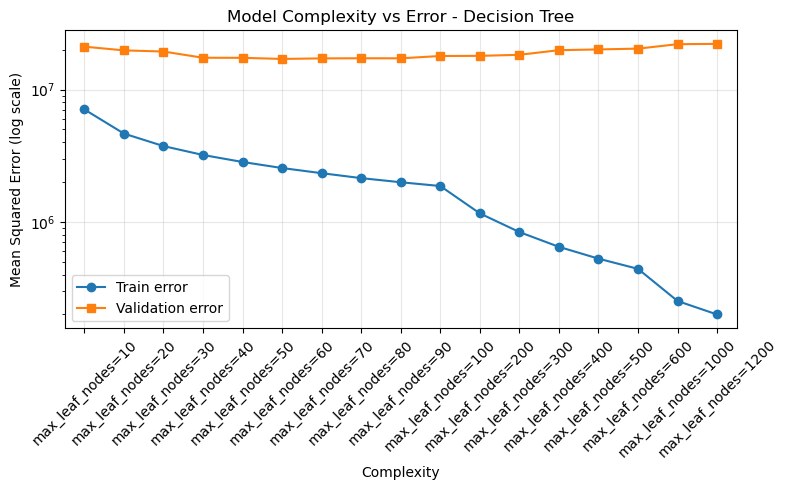


✓ ML models training complete!


In [20]:
from sklearn.preprocessing import PolynomialFeatures


ml_model_configs = {
    #"Linear Regression": {"degree": list(range(1, 4))},
    #"Ridge Regression": {"alpha": [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 50, 100]},  
    #"Linear SVR": {"C": [0.0001, 0.001, 0.01, 0.1, 1, 10, 50, 100]},  
    "Decision Tree": {"max_leaf_nodes": [10,20,30,40,50,60,70,80,90,100,200,300,400,500,600,1000,1200]},  
    #"Random Forest": {"max_depth": list(range(1, 31)) + [None]},  
    #"XGBoost": {"max_depth": list(range(2, 16))}
}

ml_complexity_rows = []

for model_name, param_dict in ml_model_configs.items():
    print(f"\nTraining {model_name}...")
    for param_name, values in param_dict.items():
        for val in values:
            X_sub, y_sub = X_tr_sub_raw, y_tr_sub_raw
            X_val_sub_local, y_val_sub_local = X_val_sub_raw, y_val_sub_raw
            
            if model_name == "Decision Tree":
                model = DecisionTreeRegressor(max_leaf_nodes=val, random_state=42)

            elif model_name == "Random Forest":
                model = RandomForestRegressor(max_depth=val, n_estimators=50, random_state=42)

            elif model_name == "XGBoost":
                model = XGBRegressor(
                    max_depth=val,
                    n_estimators=50,
                    tree_method="hist",
                    random_state=42
                )

            elif model_name == "Linear Regression":
                # For polynomial features
                poly = PolynomialFeatures(degree=val, include_bias=False)
                X_sub_poly = poly.fit_transform(X_sub)
                X_val_sub_local_poly = poly.transform(X_val_sub_local)
                model = LinearRegression()
                model.fit(X_sub_poly, y_sub)
                train_err = mean_squared_error(y_sub, model.predict(X_sub_poly))
                val_err = mean_squared_error(y_val_sub_local, model.predict(X_val_sub_local_poly))
                ml_complexity_rows.append({
                    "Model": model_name,
                    "Complexity": f"{param_name}={val}",
                    "Train error": train_err,
                    "Val error": val_err,
                    "Overfitting Index": train_err - val_err
                })
                continue  # Skip the regular fitting below
                
            elif model_name == "Ridge Regression":
                model = Ridge(alpha=val)
                
            elif model_name == "Linear SVR":
                model = LinearSVR(C=val, max_iter=5000)
            
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                model.fit(X_sub, y_sub)
            
            # Calculate errors
            train_err = mean_squared_error(y_sub, model.predict(X_sub))
            val_err = mean_squared_error(y_val_sub_local, model.predict(X_val_sub_local))
            
            # Store
            ml_complexity_rows.append({
                "Model": model_name,
                "Complexity": f"{param_name}={val}",
                "Train error": train_err,
                "Val error": val_err,
                "Overfitting Index": train_err - val_err
            })

# Create ML results table
ml_cm_df = pd.DataFrame(ml_complexity_rows)
ml_cm_df["Complexity Level"] = ml_cm_df.groupby("Model").cumcount() + 1

print("\n" + "="*80)
print("ML MODELS - Result Table 4 (Complexity vs Error):")
print("="*80)
display(ml_cm_df)

# Plot ML results
print("\nGenerating plots for ML models...")
for model in ml_cm_df["Model"].unique():
    temp = ml_cm_df[ml_cm_df["Model"] == model]
    plt.figure(figsize=(8,5))
    plt.plot(temp["Complexity Level"], temp["Train error"], marker='o', linestyle='-', label='Train error')
    plt.plot(temp["Complexity Level"], temp["Val error"], marker='s', linestyle='-', label='Validation error')
    plt.xticks(temp["Complexity Level"], temp["Complexity"], rotation=45)
    plt.xlim(0.5, temp["Complexity Level"].max() + 0.5)
    plt.yscale('log')
    plt.title(f"Model Complexity vs Error - {model}")
    plt.xlabel("Complexity")
    plt.ylabel("Mean Squared Error (log scale)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

print("\n✓ ML models training complete!")


## decision tree model complexity vs error


Training XGBoost...

ULTRA-LOW COMPLEXITY RESULTS:


,Model,Complexity,Train error,Val error,Overfitting Index,Complexity Level
0,XGBoost,max_depth=1,3.634598e+06,20952726.0,-1.731813e+07,1
1,XGBoost,max_depth=2,1.791165e+06,20530388.0,-1.873922e+07,2
2,XGBoost,max_depth=4,5.026065e+05,21725392.0,-2.122279e+07,3
3,XGBoost,max_depth=6,1.819025e+05,21642356.0,-2.146045e+07,4
4,XGBoost,max_depth=8,5.156054e+04,21365106.0,-2.131355e+07,5
5,XGBoost,max_depth=12,8.511080e+02,18831858.0,-1.883101e+07,6
6,XGBoost,max_depth=15,2.063938e+01,20279952.0,-2.027993e+07,7
7,XGBoost,max_depth=20,6.310239e-02,20366612.0,-2.036661e+07,8
8,XGBoost,max_depth=25,1.037463e-02,20675960.0,-2.067596e+07,9
9,XGBoost,max_depth=40,8.606493e-03,20617938.0,-2.061794e+07,10



✓ Results saved to 'ml_complexity_ultra_low_results.csv'

Generating plots...


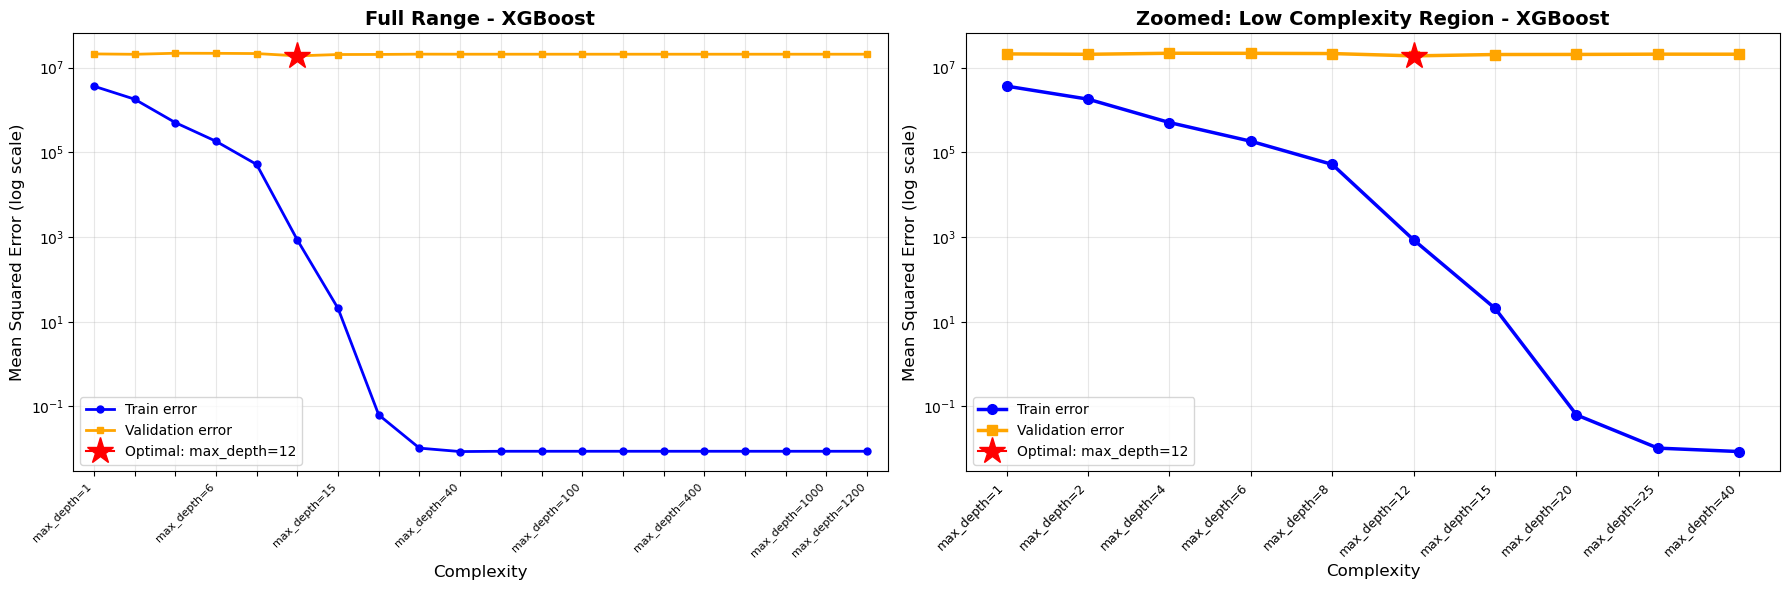

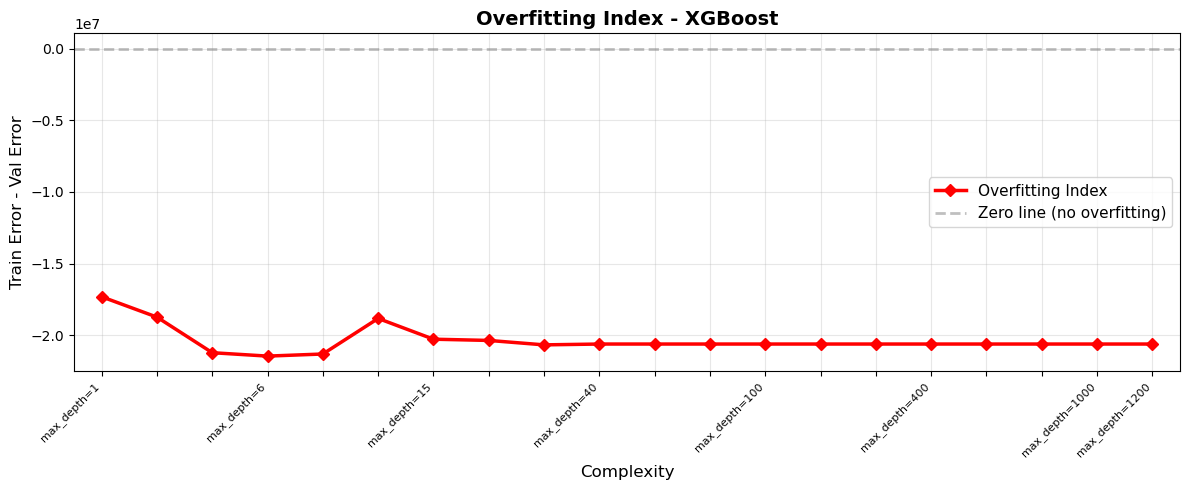


XGBoost Analysis:
  Lowest complexity tested: max_depth=1
    Train Error: 3634598.500000
    Val Error: 20952726.000000
  Optimal configuration: max_depth=12
    Train Error: 851.108032
    Val Error: 18831858.000000
  Highest complexity tested: max_depth=1200
    Train Error: 0.008744
    Val Error: 20617946.000000
    Overfitting Index: -20617945.991256
  U-shape detected: PARTIAL

✓ Ultra-low complexity analysis complete!

Key insights:
- If val error is HIGH at complexity=1-4: Clear underfitting (high bias)
- If val error DECREASES then INCREASES: Classic U-shaped curve
- If val error only DECREASES: Need even simpler models or less data


In [26]:
from sklearn.preprocessing import PolynomialFeatures


ml_model_configs = {
    #"Linear Regression": {"degree": list(range(1, 4))},
    #"Ridge Regression": {"alpha": [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 50, 100]},  
    #"Linear SVR": {"C": [0.0001, 0.001, 0.01, 0.1, 1, 10, 50, 100]},  
    #"Decision Tree": {"max_leaf_nodes": [10,20,30,40,50,60,70,80,90,100,200,300,400,500,600,1000,1200]},  
    #"Random Forest": {"max_depth": list(range(1, 31)) + [None]},  
    "XGBoost": {"max_depth":[1,2,4,6,8,12,15,20,25,40,60,80,100,150,200,400,600,800,1000,1200]}
}

ml_complexity_rows = []

for model_name, param_dict in ml_model_configs.items():
    print(f"\nTraining {model_name}...")
    for param_name, values in param_dict.items():
        for val in values:
            X_sub, y_sub = X_tr_sub_raw, y_tr_sub_raw
            X_val_sub_local, y_val_sub_local = X_val_sub_raw, y_val_sub_raw
            
            if model_name == "Decision Tree":
                model = DecisionTreeRegressor(max_leaf_nodes=val, random_state=42)

            elif model_name == "Random Forest":
                model = RandomForestRegressor(max_depth=val, n_estimators=50, random_state=42)

            elif model_name == "XGBoost":
                model = XGBRegressor(
                    max_depth=val,
                    n_estimators=50,
                    tree_method="hist",
                    random_state=42
                )

            elif model_name == "Linear Regression":
                # For polynomial features
                poly = PolynomialFeatures(degree=val, include_bias=False)
                X_sub_poly = poly.fit_transform(X_sub)
                X_val_sub_local_poly = poly.transform(X_val_sub_local)
                model = LinearRegression()
                model.fit(X_sub_poly, y_sub)
                train_err = mean_squared_error(y_sub, model.predict(X_sub_poly))
                val_err = mean_squared_error(y_val_sub_local, model.predict(X_val_sub_local_poly))
                ml_complexity_rows.append({
                    "Model": model_name,
                    "Complexity": f"{param_name}={val}",
                    "Train error": train_err,
                    "Val error": val_err,
                    "Overfitting Index": train_err - val_err
                })
                continue  # Skip the regular fitting below
                
            elif model_name == "Ridge Regression":
                model = Ridge(alpha=val)
                
            elif model_name == "Linear SVR":
                model = LinearSVR(C=val, max_iter=5000)
            
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                model.fit(X_sub, y_sub)
            
            # Calculate errors
            train_err = mean_squared_error(y_sub, model.predict(X_sub))
            val_err = mean_squared_error(y_val_sub_local, model.predict(X_val_sub_local))
            
            # Store
            ml_complexity_rows.append({
                "Model": model_name,
                "Complexity": f"{param_name}={val}",
                "Train error": train_err,
                "Val error": val_err,
                "Overfitting Index": train_err - val_err
            })
#----------------------------------------------------------------------------------------------
## Results
ml_cm_df = pd.DataFrame(ml_complexity_rows)
ml_cm_df["Complexity Level"] = ml_cm_df.groupby("Model").cumcount() + 1

print("\n" + "="*80)
print("ULTRA-LOW COMPLEXITY RESULTS:")
print("="*80)
display(ml_cm_df)

# Save
ml_cm_df.to_csv('ml_complexity_ultra_low_results.csv', index=False)
print("\n✓ Results saved to 'ml_complexity_ultra_low_results.csv'")

# Enhanced plotting with focus on left side
print("\nGenerating plots...")
for model in ml_cm_df["Model"].unique():
    temp = ml_cm_df[ml_cm_df["Model"] == model]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    
    # Left plot: Full range
    ax1.plot(temp["Complexity Level"], temp["Train error"], 
            marker='o', linestyle='-', linewidth=2, markersize=5, label='Train error', color='blue')
    ax1.plot(temp["Complexity Level"], temp["Val error"], 
            marker='s', linestyle='-', linewidth=2, markersize=5, label='Validation error', color='orange')
    
    # Mark optimal point
    optimal_idx = temp["Val error"].idxmin()
    optimal_level = temp.loc[optimal_idx, "Complexity Level"]
    optimal_val = temp.loc[optimal_idx, "Val error"]
    ax1.plot(optimal_level, optimal_val, marker='*', markersize=20, 
            color='red', label=f'Optimal: {temp.loc[optimal_idx, "Complexity"]}', zorder=5)
    
    # Adjust x-axis labels - show every 3rd label to avoid crowding
    tick_positions = temp["Complexity Level"].values
    tick_labels = temp["Complexity"].values
    show_labels = [label if i % 3 == 0 or i == len(tick_labels)-1 else '' 
                   for i, label in enumerate(tick_labels)]
    
    ax1.set_xticks(tick_positions)
    ax1.set_xticklabels(show_labels, rotation=45, ha='right', fontsize=8)
    ax1.set_xlim(0.5, temp["Complexity Level"].max() + 0.5)
    ax1.set_yscale('log')
    ax1.set_title(f"Full Range - {model}", fontsize=14, fontweight='bold')
    ax1.set_xlabel("Complexity", fontsize=12)
    ax1.set_ylabel("Mean Squared Error (log scale)", fontsize=12)
    ax1.legend(fontsize=10, loc='best')
    ax1.grid(True, alpha=0.3, which='both')
    
    # Right plot: Zoomed into low complexity (first 40% of data points)
    zoom_point = max(10, int(len(temp) * 0.4))
    temp_zoom = temp.iloc[:zoom_point]
    
    ax2.plot(temp_zoom["Complexity Level"], temp_zoom["Train error"], 
            marker='o', linestyle='-', linewidth=2.5, markersize=7, label='Train error', color='blue')
    ax2.plot(temp_zoom["Complexity Level"], temp_zoom["Val error"], 
            marker='s', linestyle='-', linewidth=2.5, markersize=7, label='Validation error', color='orange')
    
    # Mark optimal if in zoom range
    if optimal_level <= zoom_point:
        ax2.plot(optimal_level, optimal_val, marker='*', markersize=20, 
                color='red', label=f'Optimal: {temp.loc[optimal_idx, "Complexity"]}', zorder=5)
    
    ax2.set_xticks(temp_zoom["Complexity Level"])
    ax2.set_xticklabels(temp_zoom["Complexity"], rotation=45, ha='right', fontsize=9)
    ax2.set_xlim(0.5, temp_zoom["Complexity Level"].max() + 0.5)
    ax2.set_yscale('log')
    ax2.set_title(f"Zoomed: Low Complexity Region - {model}", fontsize=14, fontweight='bold')
    ax2.set_xlabel("Complexity", fontsize=12)
    ax2.set_ylabel("Mean Squared Error (log scale)", fontsize=12)
    ax2.legend(fontsize=10, loc='best')
    ax2.grid(True, alpha=0.3, which='both')
    
    plt.tight_layout()
    plt.show()
    
    # Overfitting Index plot
    plt.figure(figsize=(12, 5))
    plt.plot(temp["Complexity Level"], temp["Overfitting Index"], 
             marker='D', linestyle='-', linewidth=2.5, markersize=6, color='red', label='Overfitting Index')
    plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5, linewidth=2, label='Zero line (no overfitting)')
    plt.xticks(tick_positions, show_labels, rotation=45, ha='right', fontsize=8)
    plt.xlim(0.5, temp["Complexity Level"].max() + 0.5)
    plt.title(f"Overfitting Index - {model}", fontsize=14, fontweight='bold')
    plt.xlabel("Complexity", fontsize=12)
    plt.ylabel("Train Error - Val Error", fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Print analysis
    print(f"\n{'='*60}")
    print(f"{model} Analysis:")
    print(f"{'='*60}")
    print(f"  Lowest complexity tested: {temp.iloc[0]['Complexity']}")
    print(f"    Train Error: {temp.iloc[0]['Train error']:.6f}")
    print(f"    Val Error: {temp.iloc[0]['Val error']:.6f}")
    print(f"  Optimal configuration: {temp.loc[optimal_idx, 'Complexity']}")
    print(f"    Train Error: {temp.loc[optimal_idx, 'Train error']:.6f}")
    print(f"    Val Error: {optimal_val:.6f}")
    print(f"  Highest complexity tested: {temp.iloc[-1]['Complexity']}")
    print(f"    Train Error: {temp.iloc[-1]['Train error']:.6f}")
    print(f"    Val Error: {temp.iloc[-1]['Val error']:.6f}")
    print(f"    Overfitting Index: {temp.iloc[-1]['Overfitting Index']:.6f}")
    print(f"  U-shape detected: {'YES' if temp.iloc[-1]['Val error'] > optimal_val * 1.1 else 'PARTIAL'}")

print("\n" + "="*80)
print("✓ Ultra-low complexity analysis complete!")
print("="*80)
print("\nKey insights:")
print("- If val error is HIGH at complexity=1-4: Clear underfitting (high bias)")
print("- If val error DECREASES then INCREASES: Classic U-shaped curve")
print("- If val error only DECREASES: Need even simpler models or less data")


In [35]:
def get_epochs_for_complexity(complexity_level, total_levels):
    """
    Start with fewer epochs for simple models, increase for complex models.
    This helps show the full spectrum from underfitting to overfitting.
    """
    # Low complexity: 3-5 epochs (underfitting)
    # Medium complexity: 8-12 epochs (sweet spot)
    # High complexity: 15-20 epochs (overfitting)
    progress = complexity_level / total_levels
    if progress < 0.3:
        return 3  # Simple models - underfit
    elif progress < 0.6:
        return 8  # Medium models - balanced
    else:
        return 15  # Complex models - risk overfit



Training MLP...
  Progress: 1/25 - hidden_units=1
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step
767/767 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step
  Progress: 2/25 - hidden_units=2
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step
767/767 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step
  Progress: 3/25 - hidden_units=3
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step
767/767 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step
  Progress: 4/25 - hidden_units=4
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step
767/767 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step
  Progress: 5/25 - hidden_units=6
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step
767/767 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step
  Progress: 6/25 - hidden_units=8
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step
767/767 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step
  Pro

,Model,Complexity,Train error,Val error,Overfitting Index,Complexity Level
0,MLP,hidden_units=1,0.013373,1.287621,-1.274248,1
1,MLP,hidden_units=2,0.023274,0.804031,-0.780757,2
2,MLP,hidden_units=3,0.008690,0.430620,-0.421931,3
3,MLP,hidden_units=4,0.012309,0.431609,-0.419300,4
4,MLP,hidden_units=6,0.008308,0.480040,-0.471732,5
...,...,...,...,...,...,...
62,Temporal CNN,filters=160,0.003282,0.080316,-0.077034,18
63,Temporal CNN,filters=192,0.003540,0.037452,-0.033912,19
64,Temporal CNN,filters=256,0.002721,0.033030,-0.030310,20
65,Temporal CNN,filters=384,0.004628,0.021853,-0.017225,21



✓ Results saved to 'nn_complexity_ultra_low_results.csv'

Generating plots...


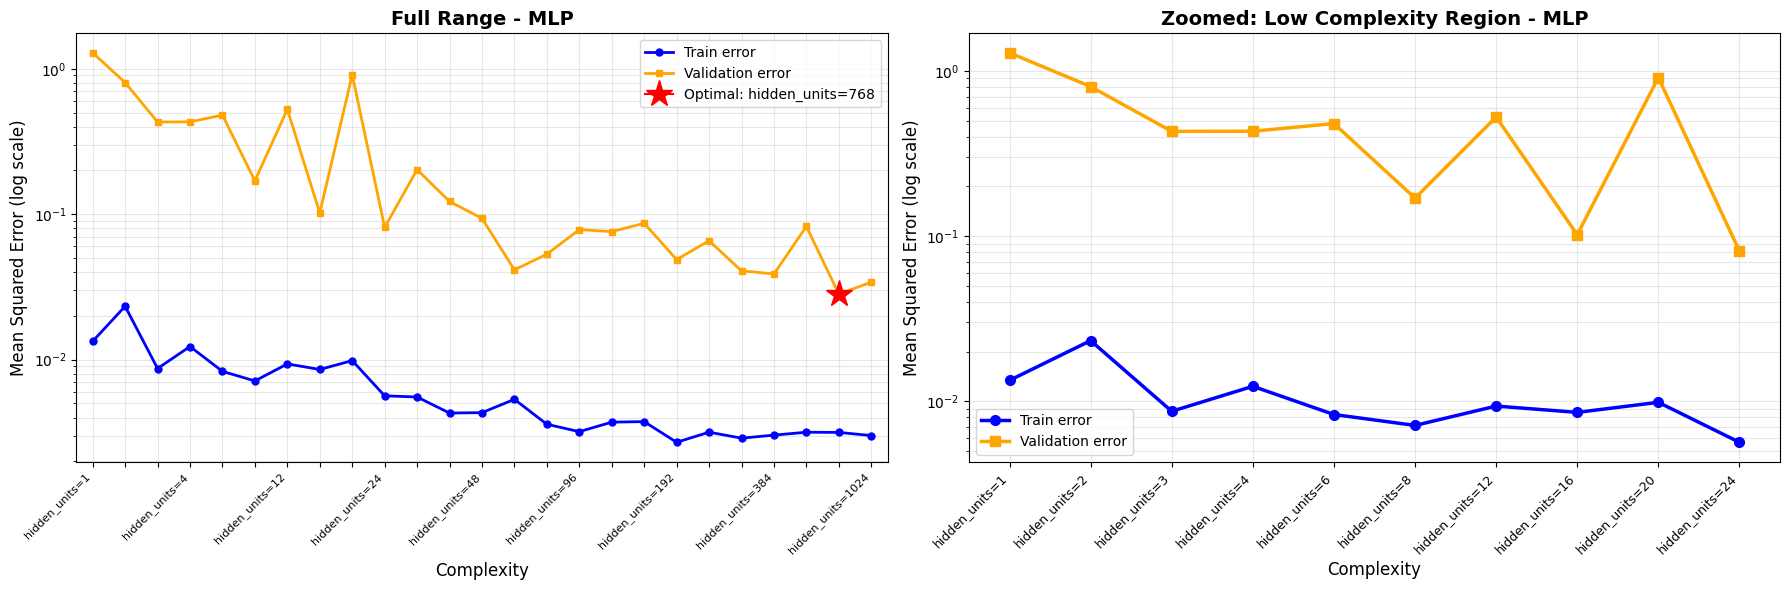

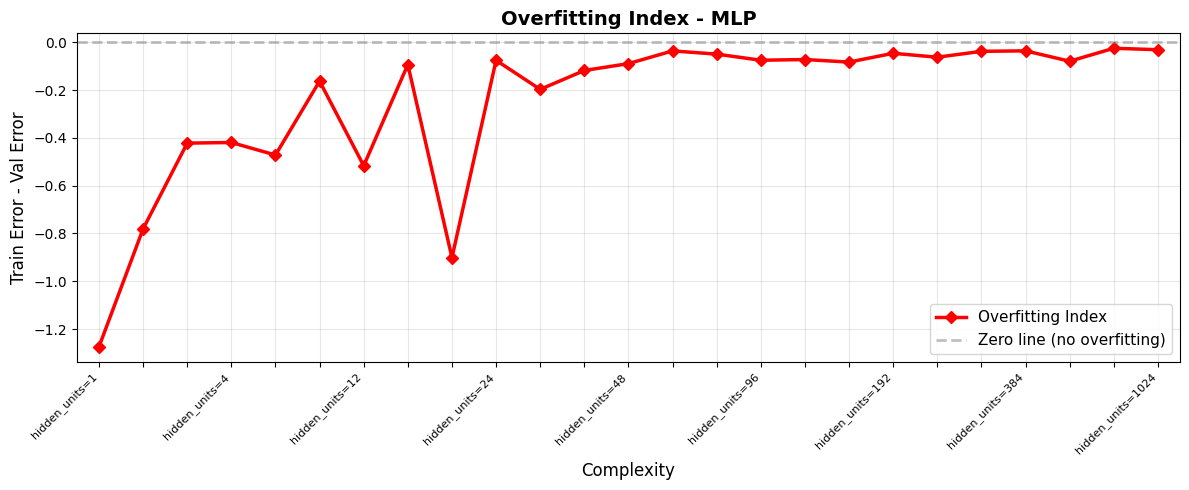


MLP Analysis:
  Lowest complexity tested: hidden_units=1
    Train Error: 0.013373
    Val Error: 1.287621
  Optimal configuration: hidden_units=768
    Train Error: 0.003160
    Val Error: 0.028210
  Highest complexity tested: hidden_units=1024
    Train Error: 0.003006
    Val Error: 0.034116
    Overfitting Index: -0.031110
  U-shape detected: YES


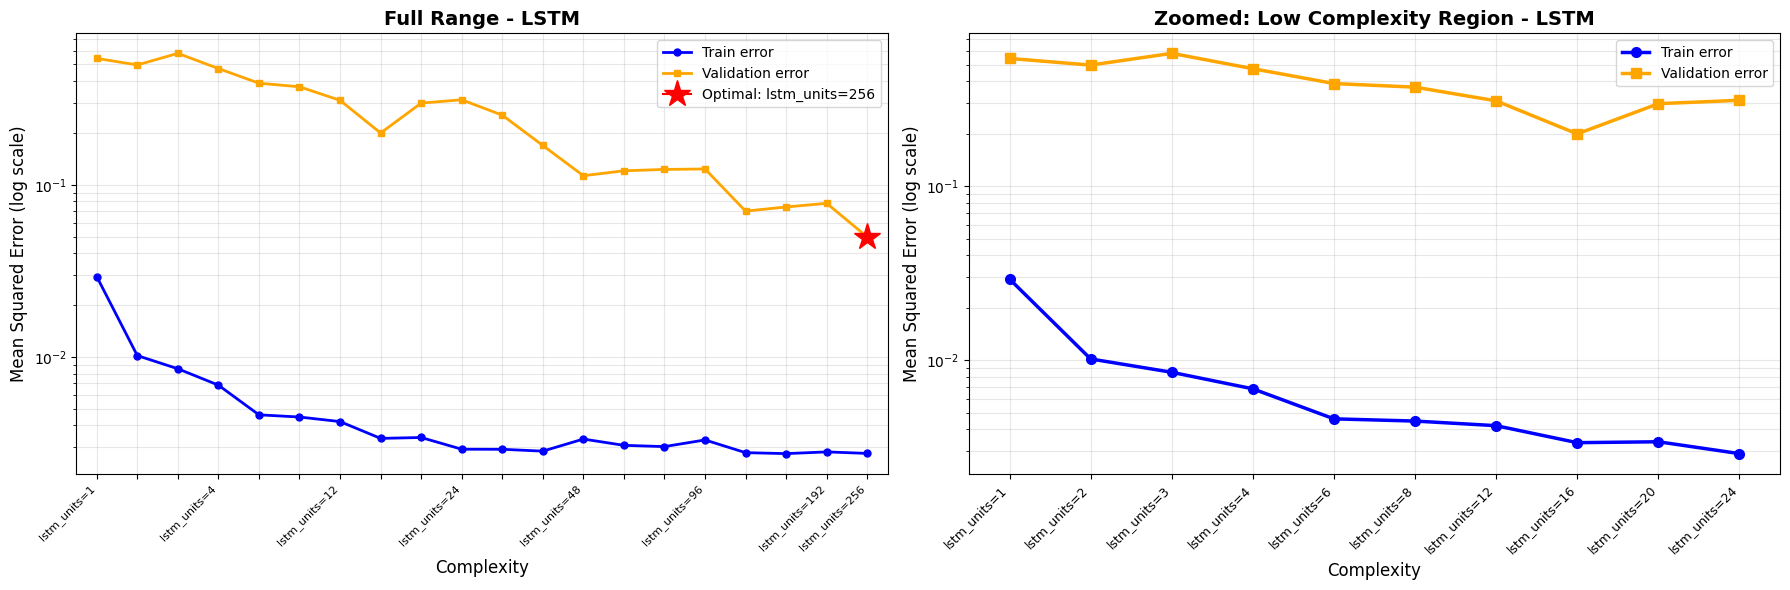

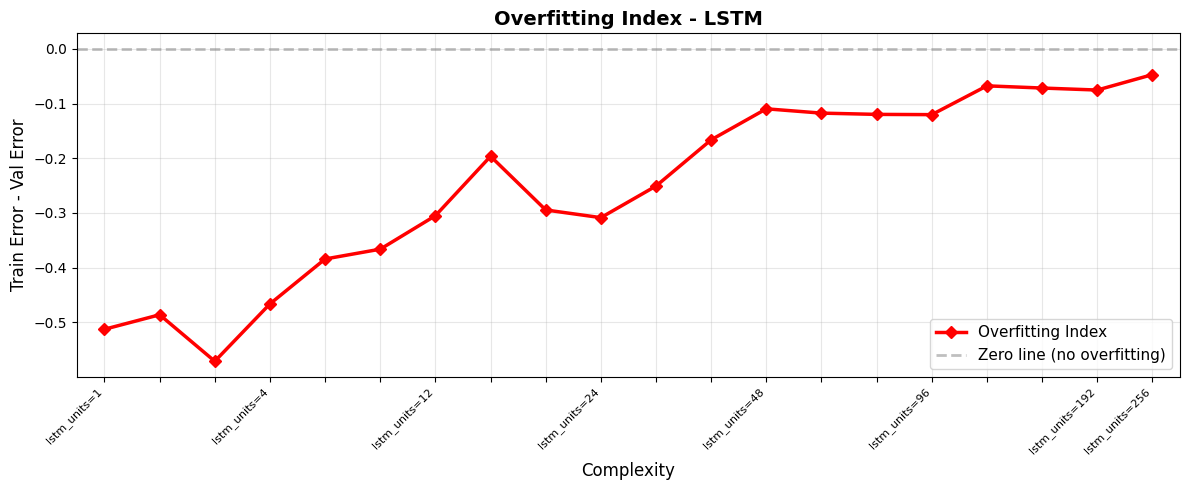


LSTM Analysis:
  Lowest complexity tested: lstm_units=1
    Train Error: 0.029268
    Val Error: 0.541983
  Optimal configuration: lstm_units=256
    Train Error: 0.002747
    Val Error: 0.049700
  Highest complexity tested: lstm_units=256
    Train Error: 0.002747
    Val Error: 0.049700
    Overfitting Index: -0.046953
  U-shape detected: PARTIAL


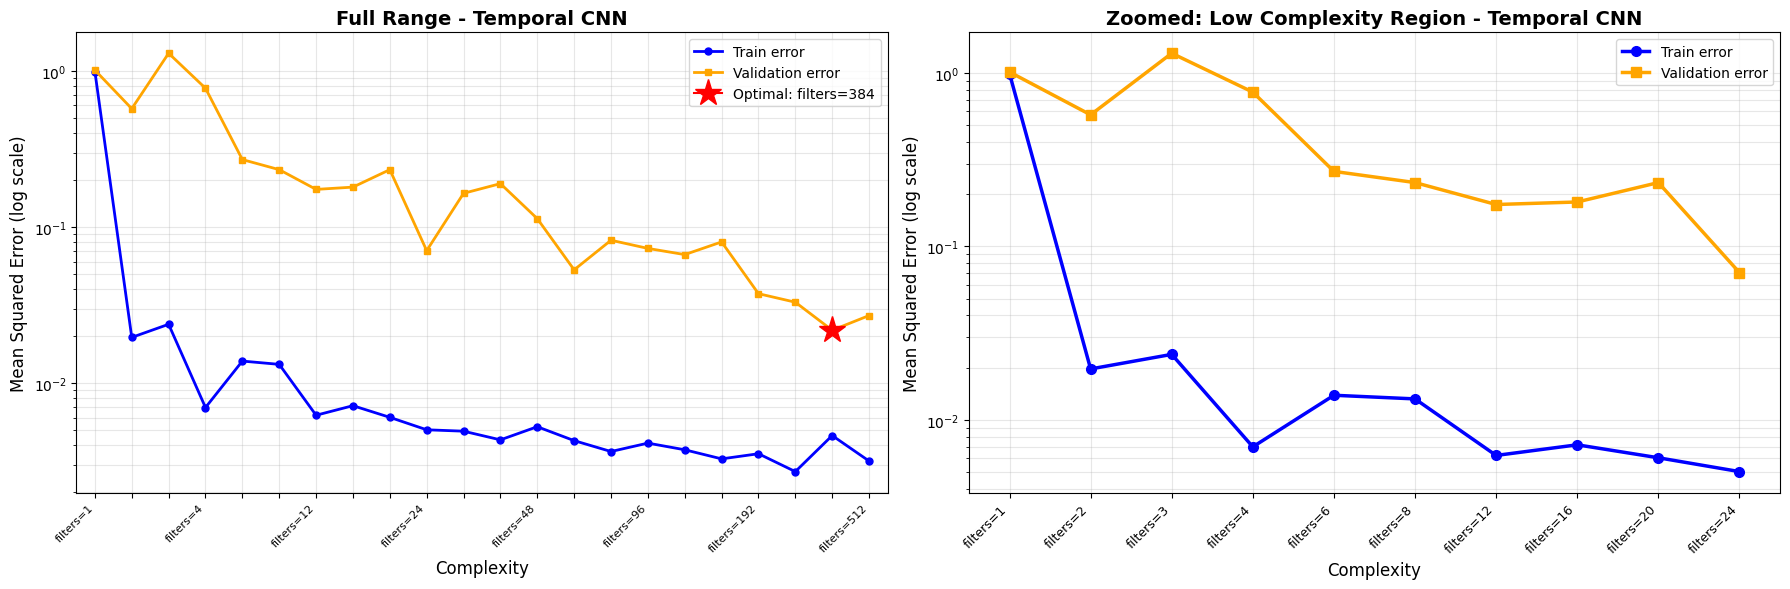

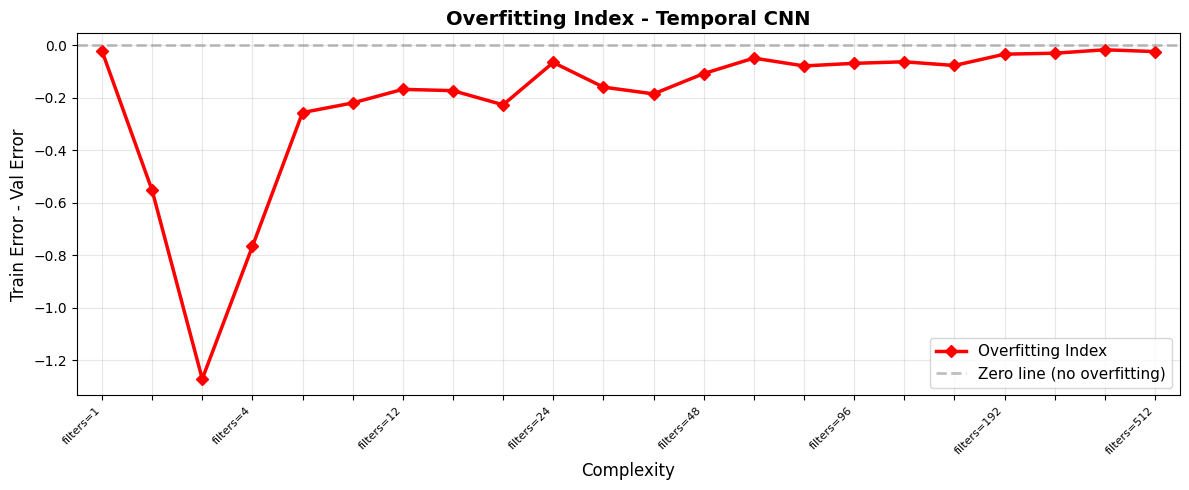


Temporal CNN Analysis:
  Lowest complexity tested: filters=1
    Train Error: 0.989151
    Val Error: 1.010569
  Optimal configuration: filters=384
    Train Error: 0.004628
    Val Error: 0.021853
  Highest complexity tested: filters=512
    Train Error: 0.003179
    Val Error: 0.027132
    Overfitting Index: -0.023953
  U-shape detected: YES

✓ Ultra-low complexity analysis complete!

Key insights:
- If val error is HIGH at complexity=1-4: Clear underfitting (high bias)
- If val error DECREASES then INCREASES: Classic U-shaped curve
- If val error only DECREASES: Need even simpler models or less data


In [ ]:
nn_model_configs = {
    # MLP: Start from 1 hidden unit
    "MLP": {"hidden_units": [1, 2, 3, 4, 6, 8, 12, 16, 20, 24, 32, 40, 48, 64, 80, 96, 128, 160, 192, 256, 320, 384, 512, 768, 1024]},
    
    # LSTM: Start from 1 unit
    "LSTM": {"lstm_units": [1, 2, 3, 4, 6, 8, 12, 16, 20, 24, 32, 40, 48, 64, 80, 96, 128, 160, 192, 256]},
    
    # Temporal CNN: Start from 1 filter
    "Temporal CNN": {"filters": [1, 2, 3, 4, 6, 8, 12, 16, 20, 24, 32, 40, 48, 64, 80, 96, 128, 160, 192, 256, 384, 512]}
}

nn_complexity_rows = []

for model_name, param_dict in nn_model_configs.items():
    print(f"\nTraining {model_name}...")
    for param_name, values in param_dict.items():
        for i, val in enumerate(values, 1):
            print(f"  Progress: {i}/{len(values)} - {param_name}={val}")
            
            X_sub, y_sub = X_tr_sub_scaled, y_tr_sub_scaled
            X_val_sub_local, y_val_sub_local = X_val_sub_scaled, y_val_sub_scaled
            
            epochs = 10
            
            if model_name == "MLP":
                model = MLP_Wrapper(hidden_units=val, epochs=epochs)
            elif model_name == "LSTM":
                model = LSTM_Wrapper(units=val, epochs=epochs)
            elif model_name == "Temporal CNN":
                model = TemporalCNN_Wrapper(filters=val, epochs=epochs)
            
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                model.fit(X_sub, y_sub)
            
            train_err = mean_squared_error(y_sub, model.predict(X_sub))
            val_err = mean_squared_error(y_val_sub_local, model.predict(X_val_sub_local))
            
            nn_complexity_rows.append({
                "Model": model_name,
                "Complexity": f"{param_name}={val}",
                "Train error": train_err,
                "Val error": val_err,
                "Overfitting Index": train_err - val_err
            })

# Results
nn_cm_df = pd.DataFrame(nn_complexity_rows)
nn_cm_df["Complexity Level"] = nn_cm_df.groupby("Model").cumcount() + 1

print("\n" + "="*80)
print("ULTRA-LOW COMPLEXITY RESULTS:")
print("="*80)
display(nn_cm_df)

# Save
nn_cm_df.to_csv('nn_complexity_ultra_low_results.csv', index=False)
print("\n✓ Results saved to 'nn_complexity_ultra_low_results.csv'")

# Enhanced plotting with focus on left side
print("\nGenerating plots...")
for model in nn_cm_df["Model"].unique():
    temp = nn_cm_df[nn_cm_df["Model"] == model]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    
    # Left plot: Full range
    ax1.plot(temp["Complexity Level"], temp["Train error"], 
            marker='o', linestyle='-', linewidth=2, markersize=5, label='Train error', color='blue')
    ax1.plot(temp["Complexity Level"], temp["Val error"], 
            marker='s', linestyle='-', linewidth=2, markersize=5, label='Validation error', color='orange')
    
    # Mark optimal point
    optimal_idx = temp["Val error"].idxmin()
    optimal_level = temp.loc[optimal_idx, "Complexity Level"]
    optimal_val = temp.loc[optimal_idx, "Val error"]
    ax1.plot(optimal_level, optimal_val, marker='*', markersize=20, 
            color='red', label=f'Optimal: {temp.loc[optimal_idx, "Complexity"]}', zorder=5)
    
    # Adjust x-axis labels - show every 3rd label to avoid crowding
    tick_positions = temp["Complexity Level"].values
    tick_labels = temp["Complexity"].values
    show_labels = [label if i % 3 == 0 or i == len(tick_labels)-1 else '' 
                   for i, label in enumerate(tick_labels)]
    
    ax1.set_xticks(tick_positions)
    ax1.set_xticklabels(show_labels, rotation=45, ha='right', fontsize=8)
    ax1.set_xlim(0.5, temp["Complexity Level"].max() + 0.5)
    ax1.set_yscale('log')
    ax1.set_title(f"Full Range - {model}", fontsize=14, fontweight='bold')
    ax1.set_xlabel("Complexity", fontsize=12)
    ax1.set_ylabel("Mean Squared Error (log scale)", fontsize=12)
    ax1.legend(fontsize=10, loc='best')
    ax1.grid(True, alpha=0.3, which='both')
    
    # Right plot: Zoomed into low complexity (first 40% of data points)
    zoom_point = max(10, int(len(temp) * 0.4))
    temp_zoom = temp.iloc[:zoom_point]
    
    ax2.plot(temp_zoom["Complexity Level"], temp_zoom["Train error"], 
            marker='o', linestyle='-', linewidth=2.5, markersize=7, label='Train error', color='blue')
    ax2.plot(temp_zoom["Complexity Level"], temp_zoom["Val error"], 
            marker='s', linestyle='-', linewidth=2.5, markersize=7, label='Validation error', color='orange')
    
    # Mark optimal if in zoom range
    if optimal_level <= zoom_point:
        ax2.plot(optimal_level, optimal_val, marker='*', markersize=20, 
                color='red', label=f'Optimal: {temp.loc[optimal_idx, "Complexity"]}', zorder=5)
    
    ax2.set_xticks(temp_zoom["Complexity Level"])
    ax2.set_xticklabels(temp_zoom["Complexity"], rotation=45, ha='right', fontsize=9)
    ax2.set_xlim(0.5, temp_zoom["Complexity Level"].max() + 0.5)
    ax2.set_yscale('log')
    ax2.set_title(f"Zoomed: Low Complexity Region - {model}", fontsize=14, fontweight='bold')
    ax2.set_xlabel("Complexity", fontsize=12)
    ax2.set_ylabel("Mean Squared Error (log scale)", fontsize=12)
    ax2.legend(fontsize=10, loc='best')
    ax2.grid(True, alpha=0.3, which='both')
    
    plt.tight_layout()
    plt.show()
    
    # Overfitting Index plot
    plt.figure(figsize=(12, 5))
    plt.plot(temp["Complexity Level"], temp["Overfitting Index"], 
             marker='D', linestyle='-', linewidth=2.5, markersize=6, color='red', label='Overfitting Index')
    plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5, linewidth=2, label='Zero line (no overfitting)')
    plt.xticks(tick_positions, show_labels, rotation=45, ha='right', fontsize=8)
    plt.xlim(0.5, temp["Complexity Level"].max() + 0.5)
    plt.title(f"Overfitting Index - {model}", fontsize=14, fontweight='bold')
    plt.xlabel("Complexity", fontsize=12)
    plt.ylabel("Train Error - Val Error", fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Print analysis
    print(f"\n{'='*60}")
    print(f"{model} Analysis:")
    print(f"{'='*60}")
    print(f"  Lowest complexity tested: {temp.iloc[0]['Complexity']}")
    print(f"    Train Error: {temp.iloc[0]['Train error']:.6f}")
    print(f"    Val Error: {temp.iloc[0]['Val error']:.6f}")
    print(f"  Optimal configuration: {temp.loc[optimal_idx, 'Complexity']}")
    print(f"    Train Error: {temp.loc[optimal_idx, 'Train error']:.6f}")
    print(f"    Val Error: {optimal_val:.6f}")
    print(f"  Highest complexity tested: {temp.iloc[-1]['Complexity']}")
    print(f"    Train Error: {temp.iloc[-1]['Train error']:.6f}")
    print(f"    Val Error: {temp.iloc[-1]['Val error']:.6f}")
    print(f"    Overfitting Index: {temp.iloc[-1]['Overfitting Index']:.6f}")
    print(f"  U-shape detected: {'YES' if temp.iloc[-1]['Val error'] > optimal_val * 1.1 else 'PARTIAL'}")

print("\n" + "="*80)
print("✓ Ultra-low complexity analysis complete!")
print("="*80)
print("\nKey insights:")
print("- If val error is HIGH at complexity=1-4: Clear underfitting (high bias)")
print("- If val error DECREASES then INCREASES: Classic U-shaped curve")
print("- If val error only DECREASES: Need even simpler models or less data")




In [ ]:
# error analysis

In [ ]:
# feature importance

## D. 5-fold cv

In [ ]:
# Part A - Step 4: 5-fold cross validation table
def cross_val_summary(model, X, y, folds=5):
    kf = KFold(n_splits=folds, shuffle=True, random_state=42)
    r2_scores = []
    mse_scores = []
    for train_idx, val_idx in kf.split(X):
        Xtr, Xv = X.iloc[train_idx], X.iloc[val_idx]
        ytr, yv = y.iloc[train_idx], y.iloc[val_idx]
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            model.fit(Xtr, ytr)
        preds = model.predict(Xv)
        r2_scores.append(r2_score(yv, preds))
        mse_scores.append(mean_squared_error(yv, preds))
    return {"Mean R2": np.mean(r2_scores), "Std R2": np.std(r2_scores),
            "Mean MSE": np.mean(mse_scores), "Std MSE": np.std(mse_scores)}

cv_models = {
    "Linear Regression": LinearRegression(),
    "Linear SVR": LinearSVR(max_iter=5000),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1),
    "XGBoost": XGBRegressor(n_estimators=50, random_state=42, n_jobs=-1,
                            tree_method=XGBOOST_TREE_METHOD if XGBOOST_TREE_METHOD != 'auto' else 'hist')
}

cv_rows = []
for name, mod in cv_models.items():
    summary = cross_val_summary(mod, X_train, y_train, folds=5)
    row = {"Model": name}
    row.update(summary)
    cv_rows.append(row)

result_table_6 = pd.DataFrame(cv_rows)
print("Result Table 6 - 5-fold Cross Validation Summary:")
display(result_table_6)


## Select winner models

In [36]:
df_table1 = result_table_1.copy()
# Quick pick via lowest RMSE per category (simple heuristics):
# Regression models: Linear Regression, Linear SVR, Ridge Regression
regression_rows = df_table1[df_table1['Model'].isin(['Linear Regression','SVR','Ridge Regression'])]
winner_regression = regression_rows.sort_values('RMSE').iloc[0]['Model'] if not regression_rows.empty else None

tree_rows = df_table1[df_table1['Model'].isin(['Decision Tree','Random Forest','XGBoost'])]
winner_tree = tree_rows.sort_values('RMSE').iloc[0]['Model'] if not tree_rows.empty else None

neural_rows = df_table1[df_table1['Model'].isin(['MLP','LSTM','Temporal CNN'])]
winner_neural = neural_rows.sort_values('RMSE').iloc[0]['Model'] if not neural_rows.empty else None

print("Winner candidates (simple RMSE heuristic):")
print("Regression winner:", winner_regression)
print("Tree-based winner:", winner_tree)
print("Neural winner:", winner_neural)


Winner candidates (simple RMSE heuristic):
Regression winner: SVR
Tree-based winner: Random Forest
Neural winner: LSTM


# Part B

## Comprehensive preprocessing


Model Configuration:
  Filters: 384
  Epochs: 50
  Batch Size: 32

SETTING UP GLOBAL TARGET SCALER
✓ Target scaler fitted on 35064 samples
  Mean: 24013.89 MW
  Std: 5469.64 MW

STEP 0: BASELINE (Part A Preprocessing)
Includes: IQR clip + Lag features + Cyclical encoding + Scaling + Post-clip

Clipping extreme scaled features...
  Clipped 13082 values (2.20%) to ±5.0

Training TCNN (filters=384, epochs=50)...


c:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1096/1096 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step
454/454 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

Step 0 Results:
  Features: 41
  Train RMSE: 236.77 MW, R²: 0.998126
  Test RMSE: 585.78 MW, R²: 0.988415
  ✓ Positive R² - Baseline established!

STEP 1: BASELINE + ROLLING STATISTICS (FIXED)
Adding rolling windows: [3, 6, 12, 24]
Found 6 lag features, 6 cyclical features.
✓ Created 8 rolling features: ['ENGLAND_WALES_DEMAND_rolling_mean_3', 'ENGLAND_WALES_DEMAND_rolling_std_3', 'ENGLAND_WALES_DEMAND_rolling_mean_6', 'ENGLAND_WALES_DEMAND_rolling_std_6', 'ENGLAND_WALES_DEMAND_rolling_mean_12', 'ENGLAND_WALES_DEMAND_rolling_std_12', 'ENGLAND_WALES_DEMAND_rolling_mean_24', 'ENGLAND_WALES_DEMAND_rolling_std_24']
✓ After dropna: Train rows = 35041, Test rows = 14498
  Num features used: 49 (+8 rolling)

Clipping extreme scaled features...
  Clipped 1 values (0.00%) to ±5.0
  Clipped 13083 values (1.84%) to ±5.0

Training TCNN (filters=384, epochs=50)...


c:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1096/1096 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
454/454 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Step 1 Results:
  Features: 49 (+8)
  Test RMSE: 333.67 MW (Δ: -252.11)
  Test R²: 0.996242

STEP 2: STEP 1 + WEATHER INTERACTIONS
Adding interactions: [('temperature_2m', 'relativehumidity_2m'), ('temperature_2m', 'wind_speed_10m'), ('wind_speed_10m', 'wind_direction_10m')]
✓ Added 3 interaction features

Clipping extreme scaled features...
  Clipped 1 values (0.00%) to ±5.0
  Clipped 13083 values (1.74%) to ±5.0

Training TCNN (filters=384, epochs=50)...


c:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1096/1096 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
454/454 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Step 2 Results:
  Features: 52 (+3)
  Test RMSE: 362.59 MW (Δ: 28.92)
  Test R²: 0.995562

COMPLETE RESULTS


,Step,Train MSE,Test MSE,Train RMSE,Test RMSE,Train MAE,Test MAE,Train R²,Test R²,Num Features
0,Step 0: Baseline,56059.457031,343140.218750,236.768784,585.781716,185.217194,467.781708,0.998126,0.988415,41
1,Step 1: + Rolling Stats,22289.562500,111334.078125,149.296894,333.667616,106.864647,277.278442,0.999255,0.996242,49
2,Step 2: + Weather Interactions,11272.394531,131473.156250,106.171534,362.592273,81.758812,295.737976,0.999623,0.995562,52



✓ Results saved to 'part_b_step1_results.csv'

🏆 BEST PREPROCESSING STEP: Step 1: + Rolling Stats
   Test RMSE: 333.67 MW
   Test R²: 0.996242
   Features: 49

GENERATING VISUALIZATIONS


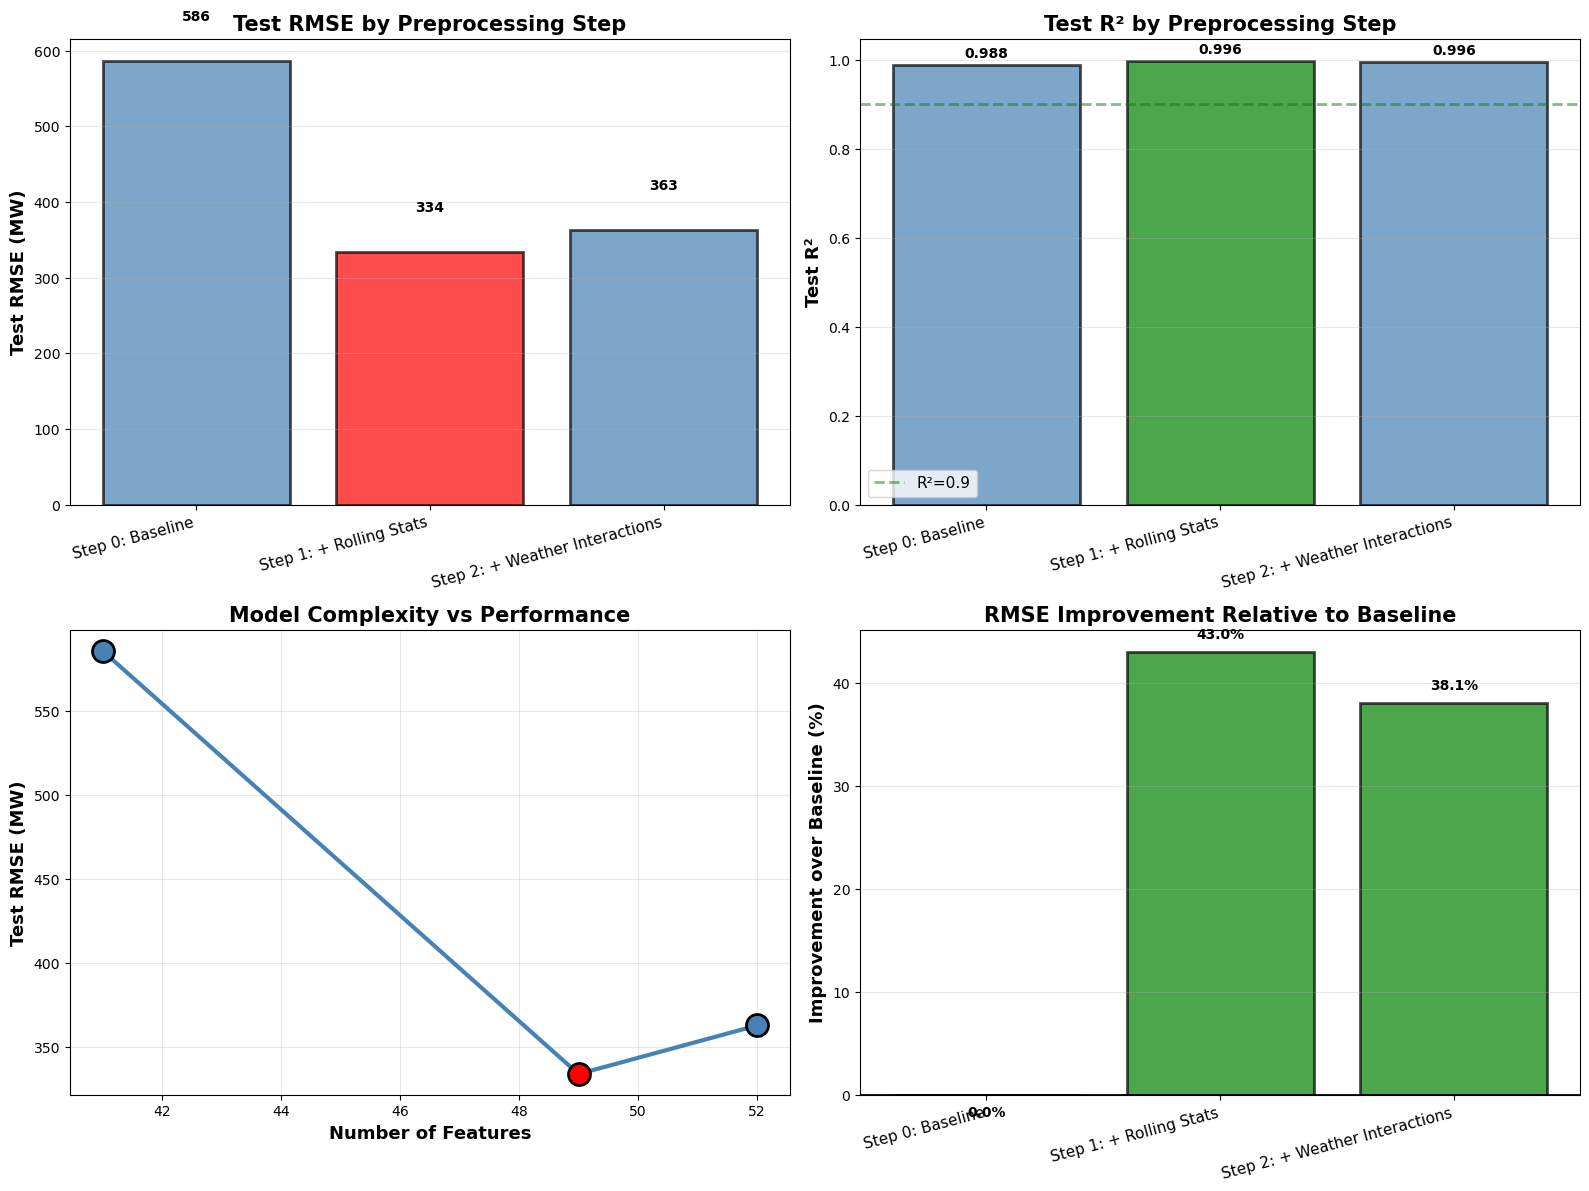

✓ Saved visualization: part_b_step1_comparison.png

✅ PART B STEP 1 COMPLETE!

Recommendation: Use Step 1: + Rolling Stats for Part B Step 2
  - Best Test RMSE: 333.67 MW
  - Best Test R²: 0.996242
  - Features: 49


In [ ]:
# ============================================================================
# CONFIGURATION
# ============================================================================

OPTIMAL_FILTERS = 384 # From ultra-low complexity analysis
EPOCHS = 50
BATCH_SIZE = 32

# Part A already includes:
# - Lag features: [1, 2, 3, 6, 12, 24] hours
# - Cyclical encoding: hour, day, month (sin/cos)

# Part B adds:
ROLLING_WINDOWS = [3, 6, 12, 24]  # Short-term trend capture
WEATHER_PAIRS = [  # Domain knowledge interactions
    ('temperature_2m', 'relativehumidity_2m'),
    ('temperature_2m', 'wind_speed_10m'),
    ('wind_speed_10m', 'wind_direction_10m')
]

print(f"\nModel Configuration:")
print(f"  Filters: {OPTIMAL_FILTERS}")
print(f"  Epochs: {EPOCHS}")
print(f"  Batch Size: {BATCH_SIZE}")

# ============================================================================
# HELPER FUNCTIONS
# ============================================================================

def clip_scaled_features(X_scaled, clip_value=5.0):
    """Clip scaled features to prevent extreme predictions"""
    X_clipped = np.clip(X_scaled, -clip_value, clip_value)
    n_clipped = np.sum(np.abs(X_scaled) > clip_value)
    if n_clipped > 0:
        pct_clipped = 100 * n_clipped / X_scaled.size
        print(f"  Clipped {n_clipped} values ({pct_clipped:.2f}%) to ±{clip_value}")
    return X_clipped

def create_rolling_features(df, target_col, windows):
    """Create rolling statistics features"""
    df_out = df.copy()
    for window in windows:
        df_out[f'{target_col}_rolling_mean_{window}'] = df_out[target_col].rolling(window=window).mean()
        df_out[f'{target_col}_rolling_std_{window}'] = df_out[target_col].rolling(window=window).std()
    return df_out

def create_interaction_features(df, feature_pairs):
    """Create interaction terms between feature pairs"""
    df_out = df.copy()
    for feat1, feat2 in feature_pairs:
        if feat1 in df_out.columns and feat2 in df_out.columns:
            df_out[f'{feat1}_x_{feat2}'] = df_out[feat1] * df_out[feat2]
    return df_out

# ============================================================================
# SETUP GLOBAL TARGET SCALER
# ============================================================================

print("\n" + "="*80)
print("SETTING UP GLOBAL TARGET SCALER")
print("="*80)

# Use the same scaler as Part A
scaler_y_global = StandardScaler()
scaler_y_global.fit(y_train_min.values.reshape(-1, 1))

print(f"✓ Target scaler fitted on {len(y_train_min)} samples")
print(f"  Mean: {scaler_y_global.mean_[0]:.2f} MW")
print(f"  Std: {scaler_y_global.scale_[0]:.2f} MW")

# Prepare dataframes with full context for feature engineering
# Note: train_df_clipped and test_df already exist from Part A
train_df_fe = train_df_clipped.copy()
test_df_fe = test_df_clipped.copy()

results = []

# ============================================================================
# STEP 0: BASELINE (Part A preprocessing)
# ============================================================================

print("\n" + "="*80)
print("STEP 0: BASELINE (Part A Preprocessing)")
print("="*80)
print("Includes: IQR clip + Lag features + Cyclical encoding + Scaling + Post-clip")

# Use the data from Part A (already has lags + cyclical encoding)
X_train_step0 = X_train_min.copy()
X_test_step0 = X_test_min.copy()
y_train_step0_original = y_train_min.values
y_test_step0_original = y_test_min.values

# Scale features
scaler_X_step0 = StandardScaler()
X_train_step0_scaled = scaler_X_step0.fit_transform(X_train_step0)
X_test_step0_scaled = scaler_X_step0.transform(X_test_step0)

# Post-scaling clip
print("\nClipping extreme scaled features...")
X_train_step0_scaled = clip_scaled_features(X_train_step0_scaled, clip_value=5.0)
X_test_step0_scaled = clip_scaled_features(X_test_step0_scaled, clip_value=5.0)

# Scale target
y_train_step0_scaled = scaler_y_global.transform(y_train_step0_original.reshape(-1, 1)).flatten()
y_test_step0_scaled = scaler_y_global.transform(y_test_step0_original.reshape(-1, 1)).flatten()

# Train
print(f"\nTraining TCNN (filters={OPTIMAL_FILTERS}, epochs={EPOCHS})...")
model_step0 = TemporalCNN_Wrapper(filters=OPTIMAL_FILTERS, epochs=EPOCHS, batch_size=BATCH_SIZE)
model_step0.fit(X_train_step0_scaled, y_train_step0_scaled)

# Predict
y_train_pred_scaled = model_step0.predict(X_train_step0_scaled)
y_test_pred_scaled = model_step0.predict(X_test_step0_scaled)

# Inverse transform
y_train_pred = scaler_y_global.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).flatten()
y_test_pred = scaler_y_global.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()

# Metrics
metrics_step0 = {
    'Step': "Step 0: Baseline",
    'Train MSE': mean_squared_error(y_train_step0_original, y_train_pred),
    'Test MSE': mean_squared_error(y_test_step0_original, y_test_pred),
    'Train RMSE': np.sqrt(mean_squared_error(y_train_step0_original, y_train_pred)),
    'Test RMSE': np.sqrt(mean_squared_error(y_test_step0_original, y_test_pred)),
    'Train MAE': mean_absolute_error(y_train_step0_original, y_train_pred),
    'Test MAE': mean_absolute_error(y_test_step0_original, y_test_pred),
    'Train R²': r2_score(y_train_step0_original, y_train_pred),
    'Test R²': r2_score(y_test_step0_original, y_test_pred),
    'Num Features': X_train_step0.shape[1]
}
results.append(metrics_step0)

print(f"\nStep 0 Results:")
print(f"  Features: {metrics_step0['Num Features']}")
print(f"  Train RMSE: {metrics_step0['Train RMSE']:.2f} MW, R²: {metrics_step0['Train R²']:.6f}")
print(f"  Test RMSE: {metrics_step0['Test RMSE']:.2f} MW, R²: {metrics_step0['Test R²']:.6f}")

if metrics_step0['Test R²'] < 0:
    print(f"  ⚠️  Negative R²! Check if Part A preprocessing was done correctly.")
else:
    print(f"  ✓ Positive R² - Baseline established!")

# ============================================================================
# STEP 1: BASELINE + ROLLING STATISTICS (FIXED)
# ============================================================================

print("\n" + "="*80)
print("STEP 1: BASELINE + ROLLING STATISTICS (FIXED)")
print("="*80)
print(f"Adding rolling windows: {ROLLING_WINDOWS}")

# Reconstruct lag/cyclical lists from X_train_min
lag_features = [col for col in X_train_min.columns if 'lag' in col]
cyclical_features = [col for col in X_train_min.columns if '_sin' in col or '_cos' in col]
base_features = [col for col in X_train_min.columns if col not in lag_features + cyclical_features]

print(f"Found {len(lag_features)} lag features, {len(cyclical_features)} cyclical features.")

# Indices for selection (assume X_train_min/X_test_min index aligns to train_df_clipped/test_df_clipped)
train_indices = X_train_min.index
test_indices  = X_test_min.index

# Work on copies from clipped data
train_df_step1 = train_df_clipped.loc[train_indices].copy()
test_df_step1  = test_df_clipped.loc[test_indices].copy()

# ----- CRITICAL FIX: re-insert lag + cyclical columns into the dataframes -----
# These features were present in X_train_min but not in train_df_clipped; copy them in (alignment by index).
cols_to_inject = lag_features + cyclical_features
missing_in_Xtrain = [c for c in cols_to_inject if c not in X_train_min.columns]
if missing_in_Xtrain:
    raise RuntimeError(f"Expected lag/cyclical cols missing from X_train_min: {missing_in_Xtrain}")

# Inject for train
train_df_step1[cols_to_inject] = X_train_min.loc[train_indices, cols_to_inject].values
# Inject for test
test_df_step1[cols_to_inject] = X_test_min.loc[test_indices, cols_to_inject].values

# Sanity check: ensure all expected columns now exist
expected_after_inject = list(X_train_min.columns)  # base + lag + cyclical as used below
still_missing_train = [c for c in expected_after_inject if c not in train_df_step1.columns]
still_missing_test  = [c for c in expected_after_inject if c not in test_df_step1.columns]
if still_missing_train or still_missing_test:
    print("WARNING: still missing columns after injection.")
    print(" missing in train_df_step1:", still_missing_train)
    print(" missing in test_df_step1: ", still_missing_test)
    # continue but will likely error later; user can inspect the prints

# Create rolling features on the full df
train_df_step1 = create_rolling_features(train_df_step1, target, ROLLING_WINDOWS)
test_df_step1  = create_rolling_features(test_df_step1,  target, ROLLING_WINDOWS)

# Get rolling feature columns
rolling_feature_cols = [col for col in train_df_step1.columns if 'rolling_mean' in col or 'rolling_std' in col]
print(f"✓ Created {len(rolling_feature_cols)} rolling features: {rolling_feature_cols}")

# Combine features: (all columns from X_train_min) + rolling
step1_feature_cols = list(X_train_min.columns) + rolling_feature_cols

# Final check: which of step1_feature_cols are actually in train_df_step1
not_present = [c for c in step1_feature_cols if c not in train_df_step1.columns]
if not_present:
    print("ERROR: The following expected columns are NOT present in train_df_step1 (will dropna -> fail):")
    print(not_present)
    # Try to continue by removing non-present columns from the feature list so dropna won't KeyError
    step1_feature_cols = [c for c in step1_feature_cols if c in train_df_step1.columns]
    print("Adjusted step1_feature_cols to existing columns. Proceeding...")

# Drop NaNs created by rolling (and any other missing)
drop_subset = step1_feature_cols + [target]
train_df_step1 = train_df_step1.dropna(subset=drop_subset)
test_df_step1  = test_df_step1.dropna(subset=drop_subset)

# Build X/y
X_train_step1 = train_df_step1[step1_feature_cols]
X_test_step1  = test_df_step1[step1_feature_cols]
y_train_step1_original = train_df_step1[target].values
y_test_step1_original  = test_df_step1[target].values

print(f"✓ After dropna: Train rows = {len(train_df_step1)}, Test rows = {len(test_df_step1)}")
print(f"  Num features used: {len(step1_feature_cols)} (+{len(rolling_feature_cols)} rolling)")

# Scale and clip as before
scaler_X_step1 = StandardScaler()
X_train_step1_scaled = scaler_X_step1.fit_transform(X_train_step1)
X_test_step1_scaled  = scaler_X_step1.transform(X_test_step1)

print("\nClipping extreme scaled features...")
X_train_step1_scaled = clip_scaled_features(X_train_step1_scaled, clip_value=5.0)############################
X_test_step1_scaled  = clip_scaled_features(X_test_step1_scaled, clip_value=5.0)

y_train_step1_scaled = scaler_y_global.transform(y_train_step1_original.reshape(-1, 1)).flatten()
y_test_step1_scaled  = scaler_y_global.transform(y_test_step1_original.reshape(-1, 1)).flatten()

# Train
print(f"\nTraining TCNN (filters={OPTIMAL_FILTERS}, epochs={EPOCHS})...")
model_step1 = TemporalCNN_Wrapper(filters=OPTIMAL_FILTERS, epochs=EPOCHS, batch_size=BATCH_SIZE)
model_step1.fit(X_train_step1_scaled, y_train_step1_scaled)

# Predict + metrics (same as before)
y_train_pred_scaled = model_step1.predict(X_train_step1_scaled)
y_test_pred_scaled  = model_step1.predict(X_test_step1_scaled)

y_train_pred = scaler_y_global.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).flatten()
y_test_pred  = scaler_y_global.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()

metrics_step1 = {
    'Step': "Step 1: + Rolling Stats",
    'Train MSE': mean_squared_error(y_train_step1_original, y_train_pred),
    'Test MSE': mean_squared_error(y_test_step1_original, y_test_pred),
    'Train RMSE': np.sqrt(mean_squared_error(y_train_step1_original, y_train_pred)),
    'Test RMSE': np.sqrt(mean_squared_error(y_test_step1_original, y_test_pred)),
    'Train MAE': mean_absolute_error(y_train_step1_original, y_train_pred),
    'Test MAE': mean_absolute_error(y_test_step1_original, y_test_pred),
    'Train R²': r2_score(y_train_step1_original, y_train_pred),
    'Test R²': r2_score(y_test_step1_original, y_test_pred),
    'Num Features': X_train_step1.shape[1]
}
results.append(metrics_step1)

print(f"\nStep 1 Results:")
print(f"  Features: {metrics_step1['Num Features']} (+{metrics_step1['Num Features'] - metrics_step0['Num Features']})")
print(f"  Test RMSE: {metrics_step1['Test RMSE']:.2f} MW (Δ: {metrics_step1['Test RMSE'] - metrics_step0['Test RMSE']:.2f})")
print(f"  Test R²: {metrics_step1['Test R²']:.6f}")
# ============================================================================
# STEP 2: ADD WEATHER INTERACTIONS
# ============================================================================

print("\n" + "="*80)
print("STEP 2: STEP 1 + WEATHER INTERACTIONS")
print("="*80)
print(f"Adding interactions: {WEATHER_PAIRS}")

# Create interactions on the step1 dataframes
train_df_step2 = create_interaction_features(train_df_step1, WEATHER_PAIRS)
test_df_step2 = create_interaction_features(test_df_step1, WEATHER_PAIRS)

# Get interaction feature columns
interaction_feature_cols = [col for col in train_df_step2.columns if '_x_' in col]
step2_feature_cols = step1_feature_cols + interaction_feature_cols

X_train_step2 = train_df_step2[step2_feature_cols]
X_test_step2 = test_df_step2[step2_feature_cols]
y_train_step2_original = train_df_step2[target].values
y_test_step2_original = test_df_step2[target].values

print(f"✓ Added {len(interaction_feature_cols)} interaction features")

# Scale and clip
scaler_X_step2 = StandardScaler()
X_train_step2_scaled = scaler_X_step2.fit_transform(X_train_step2)
X_test_step2_scaled = scaler_X_step2.transform(X_test_step2)

print("\nClipping extreme scaled features...")
X_train_step2_scaled = clip_scaled_features(X_train_step2_scaled, clip_value=5.0)
X_test_step2_scaled = clip_scaled_features(X_test_step2_scaled, clip_value=5.0)

y_train_step2_scaled = scaler_y_global.transform(y_train_step2_original.reshape(-1, 1)).flatten()
y_test_step2_scaled = scaler_y_global.transform(y_test_step2_original.reshape(-1, 1)).flatten()

# Train
print(f"\nTraining TCNN (filters={OPTIMAL_FILTERS}, epochs={EPOCHS})...")
model_step2 = TemporalCNN_Wrapper(filters=OPTIMAL_FILTERS, epochs=EPOCHS, batch_size=BATCH_SIZE)
model_step2.fit(X_train_step2_scaled, y_train_step2_scaled)

# Predict
y_train_pred_scaled = model_step2.predict(X_train_step2_scaled)
y_test_pred_scaled = model_step2.predict(X_test_step2_scaled)
y_train_pred = scaler_y_global.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).flatten()
y_test_pred = scaler_y_global.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()

# Metrics
metrics_step2 = {
    'Step': "Step 2: + Weather Interactions",
    'Train MSE': mean_squared_error(y_train_step2_original, y_train_pred),
    'Test MSE': mean_squared_error(y_test_step2_original, y_test_pred),
    'Train RMSE': np.sqrt(mean_squared_error(y_train_step2_original, y_train_pred)),
    'Test RMSE': np.sqrt(mean_squared_error(y_test_step2_original, y_test_pred)),
    'Train MAE': mean_absolute_error(y_train_step2_original, y_train_pred),
    'Test MAE': mean_absolute_error(y_test_step2_original, y_test_pred),
    'Train R²': r2_score(y_train_step2_original, y_train_pred),
    'Test R²': r2_score(y_test_step2_original, y_test_pred),
    'Num Features': X_train_step2.shape[1]
}
results.append(metrics_step2)

print(f"\nStep 2 Results:")
print(f"  Features: {metrics_step2['Num Features']} (+{metrics_step2['Num Features'] - metrics_step1['Num Features']})")
print(f"  Test RMSE: {metrics_step2['Test RMSE']:.2f} MW (Δ: {metrics_step2['Test RMSE'] - metrics_step1['Test RMSE']:.2f})")
print(f"  Test R²: {metrics_step2['Test R²']:.6f}")

# ============================================================================
# RESULTS SUMMARY
# ============================================================================

print("\n" + "="*80)
print("COMPLETE RESULTS")
print("="*80)

results_df = pd.DataFrame(results)
display(results_df)

results_df.to_csv('part_b_step1_results.csv', index=False)
print("\n✓ Results saved to 'part_b_step1_results.csv'")

best_idx = results_df['Test RMSE'].idxmin()
best_step = results_df.loc[best_idx, 'Step']
best_rmse = results_df.loc[best_idx, 'Test RMSE']

print(f"\n🏆 BEST PREPROCESSING STEP: {best_step}")
print(f"   Test RMSE: {best_rmse:.2f} MW")
print(f"   Test R²: {results_df.loc[best_idx, 'Test R²']:.6f}")
print(f"   Features: {int(results_df.loc[best_idx, 'Num Features'])}")

# ============================================================================
# VISUALIZATIONS
# ============================================================================

print("\n" + "="*80)
print("GENERATING VISUALIZATIONS")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Test RMSE
ax1 = axes[0, 0]
steps = results_df['Step']
rmse_values = results_df['Test RMSE']
colors = ['red' if i == best_idx else 'steelblue' for i in range(len(steps))]
ax1.bar(range(len(steps)), rmse_values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax1.set_xticks(range(len(steps)))
ax1.set_xticklabels(steps, rotation=15, ha='right', fontsize=11)
ax1.set_ylabel('Test RMSE (MW)', fontsize=13, fontweight='bold')
ax1.set_title('Test RMSE by Preprocessing Step', fontsize=15, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
for i, v in enumerate(rmse_values):
    ax1.text(i, v + 50, f'{v:.0f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 2: Test R²
ax2 = axes[0, 1]
r2_values = results_df['Test R²']
colors = ['green' if i == best_idx else 'steelblue' for i in range(len(steps))]
ax2.bar(range(len(steps)), r2_values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax2.set_xticks(range(len(steps)))
ax2.set_xticklabels(steps, rotation=15, ha='right', fontsize=11)
ax2.set_ylabel('Test R²', fontsize=13, fontweight='bold')
ax2.set_title('Test R² by Preprocessing Step', fontsize=15, fontweight='bold')
ax2.axhline(y=0.9, color='green', linestyle='--', alpha=0.5, linewidth=2, label='R²=0.9')
ax2.grid(axis='y', alpha=0.3)
ax2.legend(fontsize=11)
for i, v in enumerate(r2_values):
    ax2.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 3: Feature Count vs Performance
ax3 = axes[1, 0]
feature_counts = results_df['Num Features']
ax3.plot(feature_counts, rmse_values, marker='o', markersize=12, linewidth=3, color='steelblue')
for i, (fc, rmse) in enumerate(zip(feature_counts, rmse_values)):
    color = 'red' if i == best_idx else 'steelblue'
    ax3.scatter(fc, rmse, s=250, c=color, zorder=5, edgecolors='black', linewidth=2)
ax3.set_xlabel('Number of Features', fontsize=13, fontweight='bold')
ax3.set_ylabel('Test RMSE (MW)', fontsize=13, fontweight='bold')
ax3.set_title('Model Complexity vs Performance', fontsize=15, fontweight='bold')
ax3.grid(alpha=0.3)

# Plot 4: Improvement over Baseline
ax4 = axes[1, 1]
baseline_rmse = results_df.loc[0, 'Test RMSE']
improvements = [(baseline_rmse - rmse) / baseline_rmse * 100 for rmse in rmse_values]
colors = ['green' if imp > 0 else 'red' for imp in improvements]
ax4.bar(range(len(steps)), improvements, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax4.set_xticks(range(len(steps)))
ax4.set_xticklabels(steps, rotation=15, ha='right', fontsize=11)
ax4.set_ylabel('Improvement over Baseline (%)', fontsize=13, fontweight='bold')
ax4.set_title('RMSE Improvement Relative to Baseline', fontsize=15, fontweight='bold')
ax4.axhline(y=0, color='black', linestyle='-', linewidth=2)
ax4.grid(axis='y', alpha=0.3)
for i, v in enumerate(improvements):
    y_pos = v + 1 if v > 0 else v - 1
    ax4.text(i, y_pos, f'{v:.1f}%', ha='center', 
             va='bottom' if v > 0 else 'top', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('part_b_step1_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved visualization: part_b_step1_comparison.png")

print("\n" + "="*80)
print("✅ PART B STEP 1 COMPLETE!")
print("="*80)
print(f"\nRecommendation: Use {best_step} for Part B Step 2")
print(f"  - Best Test RMSE: {best_rmse:.2f} MW")
print(f"  - Best Test R²: {results_df.loc[best_idx, 'Test R²']:.6f}")
print(f"  - Features: {int(results_df.loc[best_idx, 'Num Features'])}")




In [38]:
print("=== train_df_step1 columns ===")
print(train_df_step1.columns.tolist())


=== train_df_step1 columns ===
['SETTLEMENT_DATE', 'SETTLEMENT_PERIOD', 'ND', 'TSD', 'ENGLAND_WALES_DEMAND', 'EMBEDDED_WIND_GENERATION', 'EMBEDDED_WIND_CAPACITY', 'EMBEDDED_SOLAR_GENERATION', 'EMBEDDED_SOLAR_CAPACITY', 'NON_BM_STOR', 'PUMP_STORAGE_PUMPING', 'SCOTTISH_TRANSFER', 'IFA_FLOW', 'IFA2_FLOW', 'BRITNED_FLOW', 'MOYLE_FLOW', 'EAST_WEST_FLOW', 'NEMO_FLOW', 'NSL_FLOW', 'ELECLINK_FLOW', 'VIKING_FLOW', 'GREENLINK_FLOW', 'datetime', 'time', 'temperature_2m', 'relativehumidity_2m', 'pressure_msl', 'wind_speed_10m', 'wind_direction_10m', 'precipitation', 'month', 'day', 'hour', 'minute', 'year', 'weekday', 'is_weekend', 'ENGLAND_WALES_DEMAND_lag_1', 'ENGLAND_WALES_DEMAND_lag_2', 'ENGLAND_WALES_DEMAND_lag_3', 'ENGLAND_WALES_DEMAND_lag_6', 'ENGLAND_WALES_DEMAND_lag_12', 'ENGLAND_WALES_DEMAND_lag_24', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'ENGLAND_WALES_DEMAND_rolling_mean_3', 'ENGLAND_WALES_DEMAND_rolling_std_3', 'ENGLAND_WALES_DEMAND_rolling_mean_6', 'E

In [39]:
print(X_train_min.columns.tolist())

['temperature_2m', 'relativehumidity_2m', 'pressure_msl', 'wind_speed_10m', 'wind_direction_10m', 'precipitation', 'hour', 'day', 'month', 'year', 'is_weekend', 'weekday', 'EMBEDDED_WIND_GENERATION', 'EMBEDDED_WIND_CAPACITY', 'EMBEDDED_SOLAR_GENERATION', 'EMBEDDED_SOLAR_CAPACITY', 'NON_BM_STOR', 'PUMP_STORAGE_PUMPING', 'SCOTTISH_TRANSFER', 'IFA_FLOW', 'IFA2_FLOW', 'BRITNED_FLOW', 'MOYLE_FLOW', 'EAST_WEST_FLOW', 'NEMO_FLOW', 'NSL_FLOW', 'ELECLINK_FLOW', 'VIKING_FLOW', 'GREENLINK_FLOW', 'ENGLAND_WALES_DEMAND_lag_1', 'ENGLAND_WALES_DEMAND_lag_2', 'ENGLAND_WALES_DEMAND_lag_3', 'ENGLAND_WALES_DEMAND_lag_6', 'ENGLAND_WALES_DEMAND_lag_12', 'ENGLAND_WALES_DEMAND_lag_24', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos']


## Hyperparameter tuning

### Linear SVR

### RF

## tcnn

In [ ]:

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
FIXED_FILTERS=385
class TCNN_TUNE:
    def __init__(self, input_shape, filters=FIXED_FILTERS,n_layers=1, epochs=50, batch_size=32,learning_rate=0.001, dropout_rate=0.0):
        self.input_shape = input_shape
        self.filters = filters
        self.n_layers=n_layers #add
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate 
        self.dropout_rate = dropout_rate
        self.model = self.build_model() 

    def build_model(self):
        model = Sequential([
            Conv1D(self.filters, kernel_size=1, activation='relu', input_shape=self.input_shape),
            Conv1D(max(1, self.filters//2), kernel_size=1, activation='relu'),
            
            Dropout(self.dropout_rate), 
            
            Flatten(),
            Dense(1)
        ])

        optimizer = Adam(learning_rate=self.learning_rate) 
        #optimizer = Adam(learning_rate=self.learning_rate, clipvalue=1.0)
        model.compile(optimizer=optimizer, loss='mse')
        return model
    
    def fit_predict(self, X_train, y_train, X_test):
        
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', 
            patience=5,             
            restore_best_weights=True
        )

        start_train = time.time()
        self.model.fit(X_train, y_train, epochs=self.epochs, batch_size=self.batch_size, 
                       validation_split=0.2, # Added validation split for monitoring
                       callbacks=[early_stopping], # Used Early Stopping
                       verbose=0)
        training_time = time.time() - start_train

        start_pred = time.time()
        y_pred = self.model.predict(X_test).flatten()
        inference_time = (time.time() - start_pred) / X_test.shape[0]
        return y_pred, training_time, inference_time

class TCNN_TUNE_Wrapper(BaseEstimator,RegressorMixin):
    def __init__(self, filters=FIXED_FILTERS,n_layers=1, epochs=50, batch_size=32, 
                 learning_rate=0.001, dropout_rate=0.0):
        
        self.filters = filters
        self.n_layers=n_layers #add
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.dropout_rate = dropout_rate
        self.cnn_instance = None

    def fit(self, X, y):
        X_cnn = np.expand_dims(X, axis=1) 
        input_shape = X_cnn.shape[1:] 

 
        self.cnn_instance = TCNN_TUNE(
            input_shape=input_shape,
            filters=self.filters,
            n_layers=self.n_layers,  #add
            epochs=self.epochs,
            batch_size=self.batch_size,
            learning_rate=self.learning_rate, 
            dropout_rate=self.dropout_rate    
        )
        
        # Train the model
        self.cnn_instance.fit_predict(X_train=X_cnn, y_train=y, X_test=X_cnn)
        return self
    
    def predict(self, X):
        if self.cnn_instance is None:
            raise RuntimeError("Model has not been fitted yet.")
            
        # Data conversion for prediction
        X_cnn = np.expand_dims(X, axis=1)
        

        # y_pred, _, _ = self.cnn_instance.fit_predict(X_train=X_cnn, y_train=np.zeros_like(X_cnn), X_test=X_cnn)
        # return y_pred.flatten()
        y_pred = self.cnn_instance.model.predict(X_cnn).flatten()
        return y_pred
    
    

    def get_params(self, deep=True):
        return {
            'filters': self.filters, 'epochs': self.epochs, 'batch_size': self.batch_size,
            'learning_rate': self.learning_rate, 'dropout_rate': self.dropout_rate
        }
    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self




    
    
    




In [ ]:
subsample_ratio = 0.3
N = int(len(X_train) * subsample_ratio)

#for hyperparameter tunnig
X_tr_sub_hyp = X_train_step1_scaled[:N].copy()
y_tr_sub_hyp  = y_train_step1_scaled[:N].copy()

X_test_sub_hyp=X_test_step1_scaled[:N].copy()
y_test_sub_hyp=y_test_step1_scaled[:N].copy()



In [ ]:
#X_train_step1_scaled
#y_train_step1_scaled
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform, uniform
warnings.filterwarnings("ignore")
tf.get_logger().setLevel('ERROR')
tf.random.set_seed(42)
np.random.seed(42)


FIXED_FILTERS = 385

param_distributions = {
    # Optimization & Training
    'batch_size': [32, 64, 128,256,512], 
    'learning_rate': loguniform(1e-5, 5e-3), 
    #add
    'n_layers':[1,2,3,4],
    
    # Regularization
    'dropout_rate': uniform(loc=0.0, scale=0.5), 
    
    # Fixed parameters 
    'filters': [FIXED_FILTERS],
    'epochs': [50] 
}

N_ITER_TRIALS = 25 
CV_FOLDS = 3
TOTAL_MODELS = N_ITER_TRIALS * CV_FOLDS

print(f"Starting Focused Random Search")
print(f"Starting Focused Random Search (Filters={FIXED_FILTERS})")
print(f"Total models to train: {TOTAL_MODELS} ({N_ITER_TRIALS} trials x {CV_FOLDS} folds)")
print("-" * 50)

tcnn_base = TCNN_TUNE_Wrapper(filters=FIXED_FILTERS, epochs=50)
random_search = RandomizedSearchCV(
    estimator=tcnn_base, 
    param_distributions=param_distributions, 
    n_iter=N_ITER_TRIALS, 
    scoring='neg_mean_squared_error',
    cv=CV_FOLDS,          
    verbose=2, 
    n_jobs=-1,
    random_state=42 
)

random_search.fit(X_tr_sub_hyp, y_tr_sub_hyp)



# --- 4. RESULTS ---
best_params = random_search.best_params_
BEST_LR = best_params['learning_rate']
BEST_BATCH_SIZE = best_params['batch_size']
BEST_DROPOUT = best_params['dropout_rate']
FIXED_FILTERS = best_params['filters']

best_params_df = pd.Series(random_search.best_params_).to_frame(name='Best Value')
print("\nBest Hyperparameters Found:")
print(best_params_df.to_markdown())




Starting Focused Random Search
Starting Focused Random Search (Filters=385)
Total models to train: 75 (25 trials x 3 folds)
--------------------------------------------------
Fitting 3 folds for each of 25 candidates, totalling 75 fits
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

Best Hyperparameters Found:
|               |   Best Value |
|:--------------|-------------:|
| batch_size    | 256          |
| dropout_rate  |   0.29895    |
| epochs        |  50          |
| filters       | 385          |
| learning_rate |   0.00307688 |


In [ ]:
from math import sqrt
# to use best fit parameter (tcnn)
print("TRAINING FINAL MODEL ON FULL DATA")
Best_TCNN_Wrapper = TCNN_TUNE_Wrapper(
    filters=FIXED_FILTERS, 
    epochs=best_params['epochs'], 
    batch_size=BEST_BATCH_SIZE, 
    learning_rate=BEST_LR,
    dropout_rate=BEST_DROPOUT
)

Best_TCNN=Best_TCNN_Wrapper.fit(
    X_train_step1_scaled,
    y_train_step1_scaled 

)



y_pred_train_hyp_scaled=Best_TCNN_Wrapper.predict(X_train_step1_scaled)
y_pred_test_hyp_scaled = Best_TCNN_Wrapper.predict(X_test_step1_scaled)

# R2_TRAIN = r2_score(y_train_step1_scaled, y_pred_train_hyp_scaled)
# R2_TEST = r2_score(y_test_step1_scaled, y_pred_test_hyp_scaled)

y_test_hyp = scaler_y_global.inverse_transform(y_test_step1_scaled.reshape(-1, 1)).flatten()
y_pred_test_hyp= scaler_y_global.inverse_transform(y_test_step1_scaled.reshape(-1, 1)).flatten()
y_pred_train_hyp= scaler_y_global.inverse_transform(y_pred_train_hyp_scaled.reshape(-1, 1)).flatten()
y_train_hyp= scaler_y_global.inverse_transform(y_train_step1_scaled.reshape(-1, 1)).flatten()

R2_TRAIN = r2_score(y_train_hyp, y_pred_train_hyp)
R2_TEST = r2_score(y_test_hyp, y_pred_test_hyp)

mae_hyp = mean_absolute_error(y_test_hyp, y_pred_test_hyp)
rmse_hyp = sqrt(mean_squared_error(y_test_hyp, y_pred_test_hyp))


TUNE_TCNN_performance=[]
TUNE_TCNN_performance.append({
    # Architecture and Hyperparameters
    #'Layers': N_LAYERS,
    #'Conv1D Filters': f"{FILTERS_L1} / {FILTERS_L2}",
    'Filters':best_params['filters'],
    'Batch size': best_params['batch_size'],
    'Learning rate': f"{best_params['learning_rate']:.2e}", 
    'Dropout': f"{best_params['dropout_rate']:.4f}",
    'Epoch': best_params['epochs'], 
    'Train R2': f"{R2_TRAIN:.4f}",
    #'Val R2': 'Internal (0.2 Split)', 
    'Test R2': f"{R2_TEST:.4f}",
    'MAE (MW)': f"{mae_hyp:.3f}",
    'RMSE (MW)': f"{rmse_hyp:.3f}", 
})

tcnn_result_df=pd.DataFrame(TUNE_TCNN_performance)
display(tcnn_result_df)





STAGE 2: TRAINING FINAL MODEL ON FULL DATA
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step
454/454 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step


,Filters,Batch size,Learning rate,Dropout,Epoch,Train R2,Test R2,MAE (MW),RMSE (MW)
0,385,256,3.08e-03,0.2989,50,0.9980,0.9894,455.994,560.054


### LSTM

## Ensemble Model